In [1]:
import os
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Get the data

In [2]:
df_product_prices = pd.read_csv(os.path.join("data", "product_prices_leaflets.csv"))

In [3]:
df_campaigns = pd.read_csv(os.path.join("data", "chain_campaigns.csv"))

In [4]:
df_prod_structure_sales = pd.read_csv(os.path.join("data", "product_structures_sales.csv"))

# 1. (Trying to) Understand the data

## 1.1. Product prices

In [5]:
df_product_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet
0,2056,20240312,chain,21.70,0.0000,0,NaN
1,4435,20230621,chain,18.92,0.2754,1,weekly
2,1951,20230303,competitorA,60.58,0.3524,1,NaN
3,2135,20240605,chain,55.37,0.2509,1,weekly
4,3949,20230529,chain,51.90,0.0000,0,NaN


sku = Stock Keeping Unit: unique ID of the product
<br/>
PVP = Preço de Venda ao Público: price at which a product should be sold to the general public
<br/>
Discount: Discount applied to the product price (as a fraction).

In [6]:
df_product_prices[(df_product_prices.competitor == "competitorB") & (df_product_prices.flag_promo == 1)].head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet
205,2089,20240719,competitorB,43.22,0.2811,1,weekly
311,4027,20230709,competitorB,55.37,0.2509,1,NaN
326,4425,20230804,competitorB,14.75,0.1173,1,NaN
539,4364,20230727,competitorB,34.54,0.1508,1,weekly
649,2030,20230608,competitorB,27.60,0.2518,1,NaN


In [7]:
df_product_prices.sku.nunique()

3561

In [8]:
df_product_prices.sku.unique()

array([2056, 4435, 1951, ..., 1159, 2206, 4205], shape=(3561,))

In [9]:
df_product_prices[df_product_prices.sku == 4425]

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet
326,4425,20230804,competitorB,14.75,0.1173,1,NaN
711,4425,20240219,chain,13.02,0.0000,0,NaN
2670,4425,20230228,chain,14.75,0.0000,0,NaN
2871,4425,20240207,competitorA,13.02,0.0000,0,themed
3012,4425,20231005,competitorA,13.02,0.0000,0,NaN
...,...,...,...,...,...,...,...
3108495,4425,20230918,chain,13.02,0.0000,0,NaN
3108541,4425,20230822,competitorB,13.02,0.0000,0,NaN
3111695,4425,20230928,competitorB,13.02,0.0000,0,NaN
3111784,4425,20240316,competitorA,13.02,0.2535,1,short


In [10]:
df_product_prices.competitor.unique()

array(['chain', 'competitorA', 'competitorB'], dtype=object)

In [11]:
companies = df_product_prices.competitor.unique()
for company in companies:
    oldest = df_product_prices[df_product_prices.competitor == company].time_key.min()
    most_recent = df_product_prices[df_product_prices.competitor == company].time_key.max()
    print(f"{company} has data from {oldest} to {most_recent}")

chain has data from 20230103 to 20241028
competitorA has data from 20230103 to 20241028
competitorB has data from 20230103 to 20241028


In [12]:
df_product_prices.isna().sum()

sku                 0
time_key            0
competitor          0
pvp_was             0
discount            0
flag_promo          0
leaflet       2510555
dtype: int64

In [13]:
df_product_prices[df_product_prices.pvp_was <= 0]

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet


In [14]:
df_product_prices[df_product_prices.discount < 0]

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet
94574,1637,20230103,competitorB,29.33,-0.4143,0,NaN
208992,4256,20230123,competitorB,17.18,-0.2020,0,NaN
416790,1744,20230123,competitorB,44.95,-0.1546,0,NaN
589991,3516,20230123,competitorB,25.86,-0.0673,0,NaN
651940,2241,20230206,competitorB,33.33,-0.0780,0,NaN
768775,4456,20230123,competitorB,21.70,-0.0318,0,NaN
790136,2598,20230106,competitorB,27.60,-0.5029,0,NaN
873827,4149,20230130,competitorB,43.22,-0.2649,0,NaN
972893,2598,20230104,competitorB,27.60,-0.5029,0,NaN
978058,4192,20230106,competitorB,34.54,-2.0307,0,NaN


In [15]:
df_product_prices.flag_promo.unique()

array([0, 1])

In [16]:
df_product_prices.leaflet.unique()

array([nan, 'weekly', 'short', 'themed'], dtype=object)

In [17]:
df_product_prices.shape

(3112140, 7)

In [18]:
df_product_prices = df_product_prices.drop_duplicates(ignore_index=True)

In [19]:
df_product_prices.shape

(3112140, 7)

In [20]:
df_product_prices[(df_product_prices.time_key == 20230106) & (df_product_prices.sku == 1626) & (df_product_prices.competitor == 'chain')]

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet
2172770,1626,20230106,chain,27.6,0.2518,1,short
2685264,1626,20230106,chain,27.6,0.2518,1,weekly


In [21]:
df_product_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet
0,2056,20240312,chain,21.70,0.0000,0,NaN
1,4435,20230621,chain,18.92,0.2754,1,weekly
2,1951,20230303,competitorA,60.58,0.3524,1,NaN
3,2135,20240605,chain,55.37,0.2509,1,weekly
4,3949,20230529,chain,51.90,0.0000,0,NaN


## 1.2. Campaigns

In [22]:
df_campaigns.head()

,competitor,start_date,end_date,chain_campaign
0,chain,2024-08-12,2024-08-18,C2
1,competitorA,2023-09-22,2023-09-25,A2
2,chain,2024-09-23,2024-09-29,C1
3,chain,2024-04-08,2024-04-14,C1
4,competitorA,2023-10-20,2023-10-23,A2


In [23]:
df_campaigns.chain_campaign.unique()

array(['C2', 'A2', 'C1', 'A3', 'A1'], dtype=object)

In [24]:
df_campaigns.competitor.unique()

array(['chain', 'competitorA'], dtype=object)

In [25]:
companies = df_campaigns.competitor.unique()
for company in companies:
    oldest = df_campaigns[df_campaigns.competitor == company].start_date.min()
    most_recent = df_campaigns[df_campaigns.competitor == company].end_date.max()
    print(f"{company} has data from {oldest} to {most_recent}")

chain has data from 2023-01-03 to 2024-10-27
competitorA has data from 2023-01-21 to 2024-10-27


Unfortunately we cannot disclose more information about these campaigns. If in your analysis you are able to map campaign types to specific types of promotions, please do mention it, though.

## 1.3. Product Structure

In [26]:
df_prod_structure_sales.head()

,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,time_key,quantity
0,3020206,30202,302,3,3111,20230618,18.6840
1,3020608,30206,302,3,3278,20240731,396.1008
2,3020809,30208,302,3,3603,20230807,6.2280
3,3020608,30206,302,3,4604,20230131,27.4032
4,3040808,30408,304,3,3041,20230906,6.2280


structure_level_i: Identifies the structure (at level i)  to which a product belongs. Granularity increases from structure level 1 to 4.
</br>
quantity: Quantity of the product sold at Retailz

In [27]:
df_prod_structure_sales.shape

(1864594, 7)

In [28]:
df_prod_structure_sales[df_prod_structure_sales.sku == 3111].head()

,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,time_key,quantity
0,3020206,30202,302,3,3111,20230618,18.6840
15,3020206,30202,302,3,3111,20231231,7.4736
28,3020206,30202,302,3,3111,20230630,9.9648
62,3020206,30202,302,3,3111,20230304,27.4032
75,3020206,30202,302,3,3111,20240309,3.7368


In [29]:
df_prod_structure_sales.nunique()

structure_level_4      366
structure_level_3       82
structure_level_2       13
structure_level_1        3
sku                   3605
time_key               665
quantity             83680
dtype: int64

In [30]:
oldest = df_prod_structure_sales.time_key.min()
most_recent = df_prod_structure_sales.time_key.max()
print(f"We have sales data from {oldest} to {most_recent}")

We have sales data from 20230103 to 20241028


# 2. Treating the data
## 2.1. Product prices

In [31]:
df_product_prices = df_product_prices[df_product_prices.discount >= 0]

In [32]:
df_product_prices[df_product_prices.discount < 0]

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet


In [33]:
df_product_prices['price_final'] = df_product_prices['pvp_was'] * (1 - df_product_prices['discount'])

In [34]:
df_product_prices['time_key'] = pd.to_datetime(df_product_prices['time_key'], format='%Y%m%d')

## 2.2. Campaigns

In [35]:
df_campaigns['start_date'] = pd.to_datetime(df_campaigns['start_date'], format='%Y-%m-%d')
df_campaigns['end_date'] = pd.to_datetime(df_campaigns['end_date'], format='%Y-%m-%d')

## 2.3. Product Structure

In [36]:
df_prod_structure_sales = df_prod_structure_sales[df_prod_structure_sales.quantity >= 0]

In [37]:
df_prod_structure_sales[df_prod_structure_sales.quantity < 0]

,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,time_key,quantity


In [38]:
df_prod_structure_sales['time_key'] = pd.to_datetime(df_prod_structure_sales['time_key'], format='%Y%m%d')

In [39]:
df_prod_structure = df_prod_structure_sales.drop(columns=['time_key', 'quantity']).drop_duplicates()

In [40]:
df_prod_structure.shape

(3605, 5)

In [41]:
df_prod_structure = df_prod_structure.set_index('sku')

In [42]:
df_prod_structure.head()

,structure_level_4,structure_level_3,structure_level_2,structure_level_1
sku,,,,
3111,3020206,30202,302,3
3278,3020608,30206,302,3
3603,3020809,30208,302,3
4604,3020608,30206,302,3
3041,3040808,30408,304,3


# 3. General Analysis
Understand how seasonality, promotional campaigns and customer demand afect the prices
## 3.1. Data Distribution

In [43]:
competitors = df_product_prices.competitor.unique()
competitors_amount = {}
for competitor in competitors:
    amount = df_product_prices[df_product_prices.competitor == competitor].shape[0]
    competitors_amount[competitor] = amount
    print(f"{competitor} has {amount} entries")

chain has 1749087 entries
competitorA has 1094290 entries
competitorB has 268723 entries


In [44]:
for competitor in competitors_amount:
    perc = (competitors_amount[competitor] / df_product_prices.shape[0]) * 100
    print(f"{competitor} has {perc}% of the total entries")

chain has 56.20278911346036% of the total entries
competitorA has 35.16243051315831% of the total entries
competitorB has 8.634780373381318% of the total entries


In [45]:
chain_campaigns = ['C1', 'C2']
a_campaigns = ['A1', 'A2', 'A3']

In [46]:
competitors_amount = {}
for competitor in competitors:
    amount = df_campaigns[df_campaigns.competitor == competitor].shape[0]
    competitors_amount[competitor] = amount
    print(f"{competitor} has {amount} entries")
for competitor in competitors_amount:
    perc = (competitors_amount[competitor] / df_campaigns.shape[0]) * 100
    print(f"{competitor} has {perc}% of the total entries")

chain has 53 entries
competitorA has 46 entries
competitorB has 0 entries
chain has 53.535353535353536% of the total entries
competitorA has 46.464646464646464% of the total entries
competitorB has 0.0% of the total entries


In [47]:
df_time_prices = df_product_prices.groupby(['time_key', 'competitor']).agg({'price_final': 'count'})

In [48]:
df_time_prices = df_time_prices.rename(columns={'price_final': 'count'})

<Axes: xlabel='time_key'>

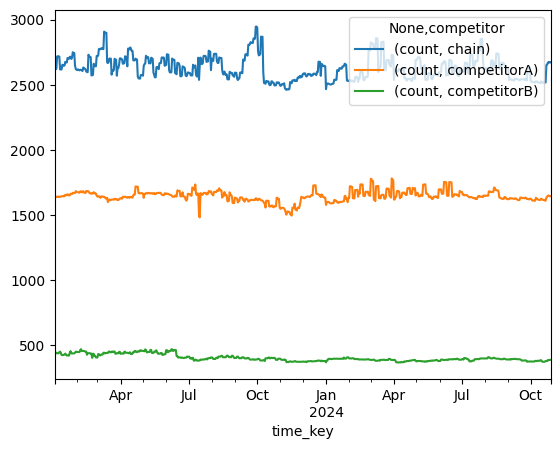

In [49]:
df_time_prices.unstack().plot.line()

The amount of data per period of time is fairly constant for the different competitors.

In [50]:
df_cat_prices = df_product_prices.merge(df_prod_structure, left_on='sku', right_index=True)
df_cat_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000,3021101,30211,302,3
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432,3030708,30307,303,3
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608,3020806,30208,302,3
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667,3010801,30108,301,3
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000,1010407,10104,101,1


In [51]:
structures_level_1 = df_cat_prices.structure_level_1.unique()
structures_amount = {}
for structure in structures_level_1:
    amount = df_cat_prices[df_cat_prices.structure_level_1 == structure].shape[0]
    structures_amount[structure] = amount
    print(f"There are {amount} entries for category {structure}")
for structure in structures_amount:
    perc = (structures_amount[structure] / df_cat_prices.shape[0]) * 100
    print(f"{structure} has {perc}% of the total entries")

There are 1833447 entries for category 3
There are 594682 entries for category 1
There are 683969 entries for category 2
3 has 58.91353678451% of the total entries
1 has 19.108717013410246% of the total entries
2 has 21.977746202079754% of the total entries


In [52]:
structures_level_2 = df_cat_prices.structure_level_2.unique()
structures_amount = {}
for structure in structures_level_2:
    amount = df_cat_prices[df_cat_prices.structure_level_2 == structure].shape[0]
    structures_amount[structure] = amount
    print(f"There are {amount} entries for category {structure}")
for structure in structures_amount:
    perc = (structures_amount[structure] / df_cat_prices.shape[0]) * 100
    print(f"{structure} has {perc}% of the total entries")

There are 776368 entries for category 302
There are 469111 entries for category 303
There are 178355 entries for category 301
There are 142854 entries for category 101
There are 558094 entries for category 202
There are 215048 entries for category 305
There are 125875 entries for category 201
There are 34413 entries for category 106
There are 217164 entries for category 103
There are 154343 entries for category 102
There are 194565 entries for category 304
There are 30204 entries for category 105
There are 15704 entries for category 104
302 has 24.94677224174817% of the total entries
303 has 15.07378623680874% of the total entries
301 has 5.731021323878618% of the total entries
101 has 4.590279612017359% of the total entries
202 has 17.933047095560614% of the total entries
305 has 6.910065171469536% of the total entries
201 has 4.044699106519139% of the total entries
106 has 1.1057813732086843% of the total entries
103 has 6.978057888922522% of the total entries
102 has 4.9594517910425

In [53]:
structures_level_1 = df_prod_structure.structure_level_1.unique()
structures_amount = {}
for structure in structures_level_1:
    amount = df_prod_structure[df_prod_structure.structure_level_1 == structure].shape[0]
    structures_amount[structure] = amount
    print(f"There are {amount} entries for category {structure}")
for structure in structures_amount:
    perc = (structures_amount[structure] / df_prod_structure.shape[0]) * 100
    print(f"{structure} has {perc}% of the total entries")

There are 2091 entries for category 3
There are 778 entries for category 2
There are 736 entries for category 1
3 has 58.00277392510402% of the total entries
2 has 21.58113730929265% of the total entries
1 has 20.41608876560333% of the total entries


In [54]:
structures_level_2 = df_prod_structure.structure_level_2.unique()
structures_amount = {}
for structure in structures_level_2:
    amount = df_prod_structure[df_prod_structure.structure_level_2 == structure].shape[0]
    structures_amount[structure] = amount
    print(f"There are {amount} entries for category {structure}")
for structure in structures_amount:
    perc = (structures_amount[structure] / df_prod_structure.shape[0]) * 100
    print(f"{structure} has {perc}% of the total entries")

There are 804 entries for category 302
There are 210 entries for category 304
There are 492 entries for category 303
There are 650 entries for category 202
There are 44 entries for category 105
There are 268 entries for category 103
There are 223 entries for category 301
There are 362 entries for category 305
There are 222 entries for category 101
There are 128 entries for category 201
There are 46 entries for category 106
There are 129 entries for category 102
There are 27 entries for category 104
302 has 22.30235783633842% of the total entries
304 has 5.825242718446602% of the total entries
303 has 13.647711511789181% of the total entries
202 has 18.030513176144243% of the total entries
105 has 1.2205270457697643% of the total entries
103 has 7.434119278779473% of the total entries
301 has 6.185852981969487% of the total entries
305 has 10.041608876560334% of the total entries
101 has 6.158113730929265% of the total entries
201 has 3.5506241331484047% of the total entries
106 has 1.2

## 3.2. Seasonality

In [55]:
df_cat_prices = df_product_prices.merge(df_prod_structure, left_on='sku', right_index=True)
df_cat_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000,3021101,30211,302,3
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432,3030708,30307,303,3
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608,3020806,30208,302,3
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667,3010801,30108,301,3
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000,1010407,10104,101,1


In [56]:
# all competitors at once:
df_cat1_prices = df_cat_prices.groupby(['time_key', 'structure_level_1']).agg({'price_final': 'mean'})
df_cat1_prices = df_cat1_prices.sort_index()

In [57]:
df_cat1_prices.head()

price_final
time_key   structure_level_1             
2023-01-03 1                    46.133272
           2                    53.008441
           3                    50.427028
2023-01-04 1                    46.111244
           2                    52.944990

<Axes: xlabel='time_key'>

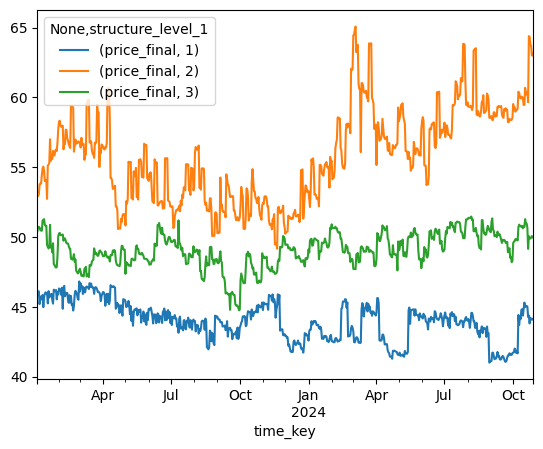

In [58]:
df_cat1_prices.unstack().plot.line()

<Axes: xlabel='time_key'>

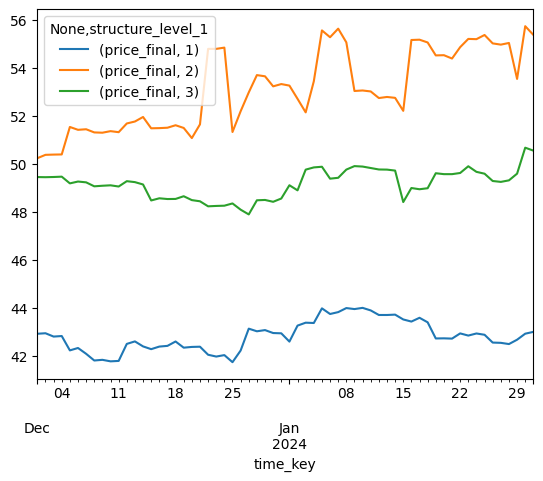

In [59]:
df_cat1_prices.unstack()['12/01/2023':'01/31/2024'].plot.line()

<Axes: xlabel='time_key'>

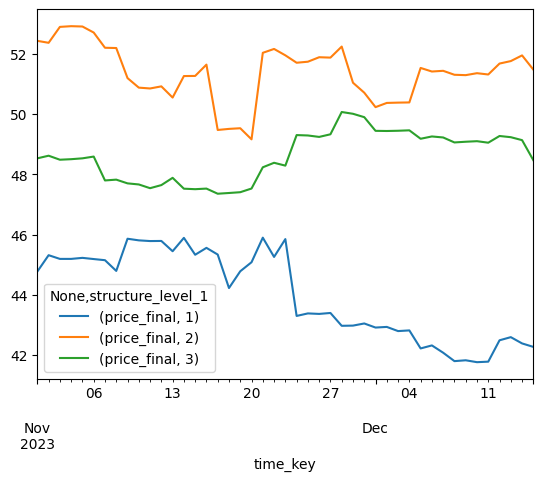

In [60]:
# black friday: 24 November 2023
df_cat1_prices.unstack()['11/01/2023':'12/15/2023'].plot.line()

<Axes: xlabel='time_key'>

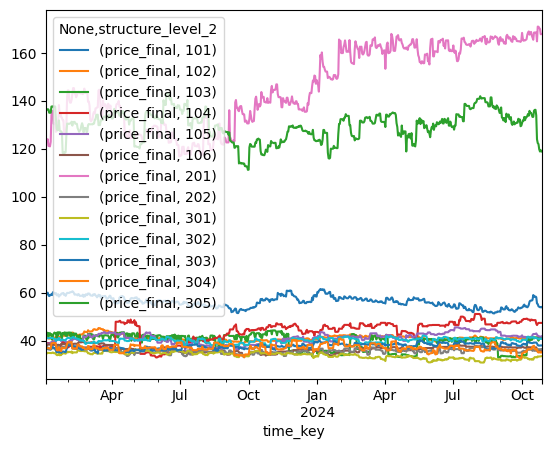

In [61]:
df_cat2_prices = df_cat_prices.groupby(['time_key', 'structure_level_2']).agg({'price_final': 'mean'})
df_cat2_prices = df_cat2_prices.sort_index()
df_cat2_prices.unstack().plot.line()

<Axes: xlabel='time_key'>

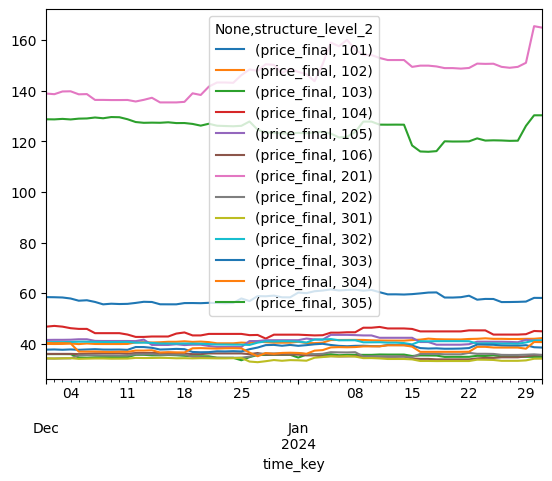

In [62]:
df_cat2_prices.unstack()['12/01/2023':'01/31/2024'].plot.line()

<Axes: xlabel='time_key'>

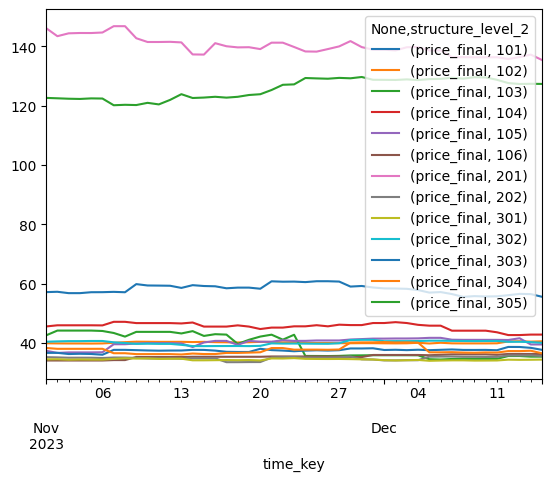

In [63]:
# black friday: 24 November 2023
df_cat2_prices.unstack()['11/01/2023':'12/15/2023'].plot.line()

<Axes: xlabel='time_key'>

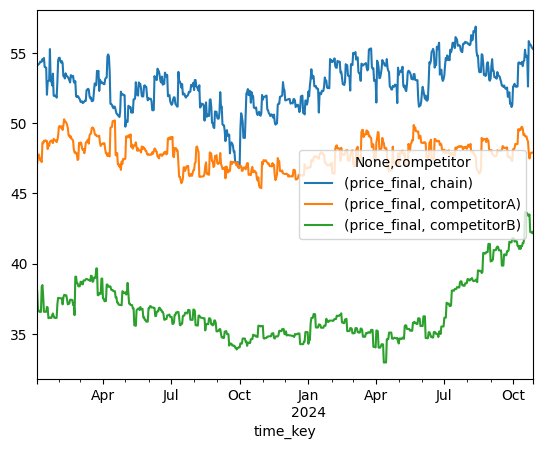

In [64]:
# all products at once:
df_chains_prices = df_cat_prices.groupby(['time_key', 'competitor']).agg({'price_final': 'mean'})
df_chains_prices = df_chains_prices.sort_index()
df_chains_prices.unstack().plot.line()

<Axes: xlabel='time_key'>

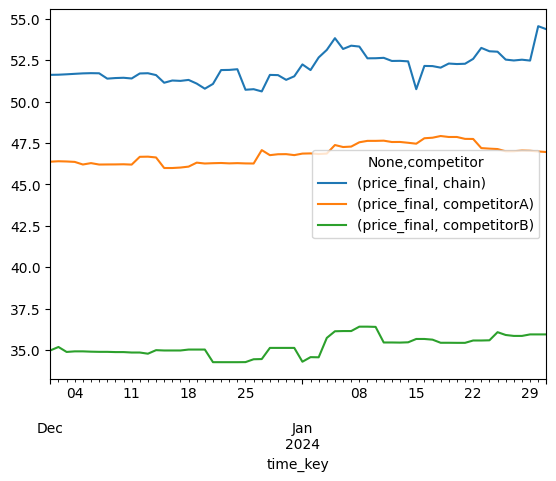

In [65]:
df_chains_prices.unstack()['12/01/2023':'01/31/2024'].plot.line()

<Axes: xlabel='time_key'>

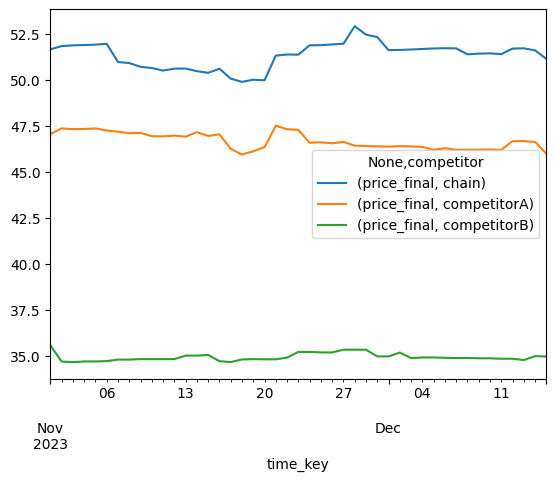

In [66]:
# black friday: 24 November 2023
df_chains_prices.unstack()['11/01/2023':'12/15/2023'].plot.line()

<Axes: xlabel='time_key'>

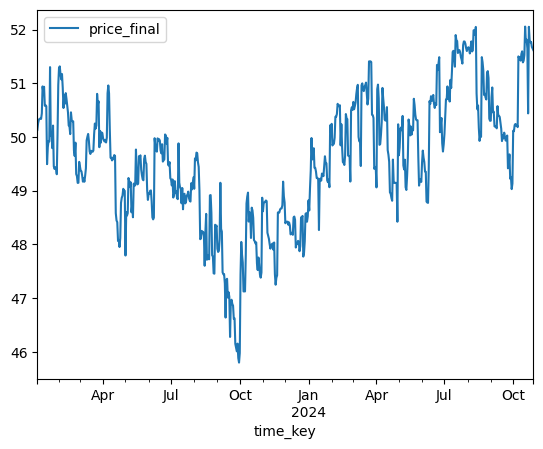

In [67]:
# everything everywhere all at once:
df_prices = df_cat_prices.groupby('time_key').agg({'price_final': 'mean'})
df_prices = df_prices.sort_index()
df_prices.plot.line()

<Axes: xlabel='time_key'>

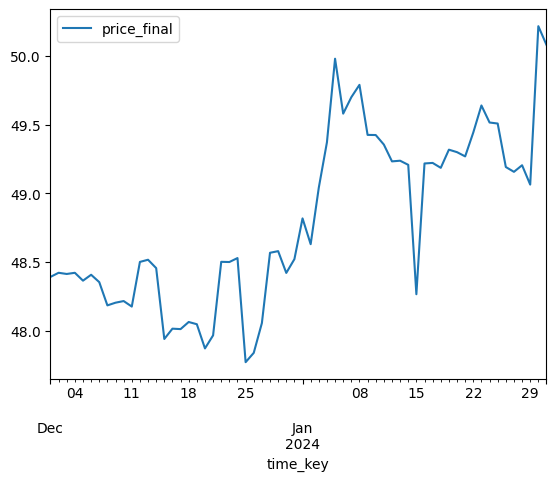

In [68]:
df_prices.loc['12/01/2023':'01/31/2024'].plot.line()

<Axes: xlabel='time_key'>

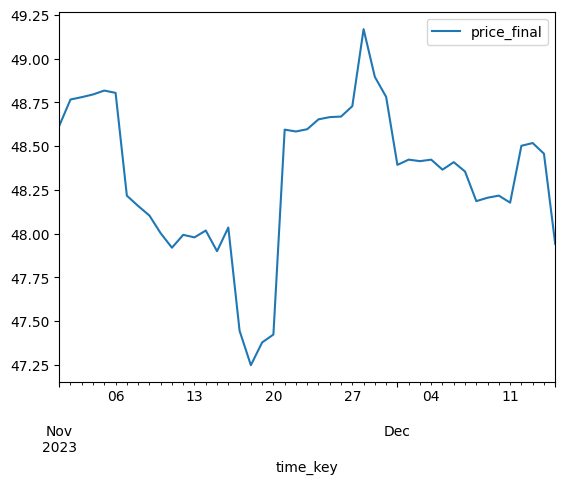

In [69]:
# black friday: 24 November 2023
df_prices.loc['11/01/2023':'12/15/2023'].plot.line()

In [70]:
df_prices.head()

,price_final
time_key,
2023-01-03,50.130574
2023-01-04,50.256493
2023-01-05,50.317711
2023-01-06,50.338582
2023-01-07,50.341093


In [71]:
# making it stationary
df_prices_log = df_prices.map(np.log)
df_prices_log_detrend = df_prices_log.diff()
df_prices_log_detrend_without_nans = df_prices_log_detrend.dropna()

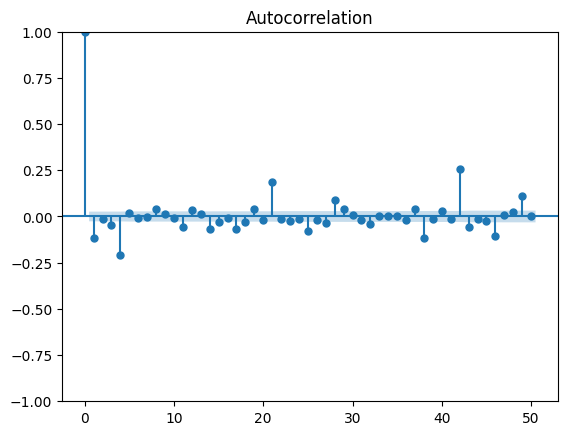

In [72]:
plot_acf(df_prices_log_detrend_without_nans, alpha=0.5, lags=50);

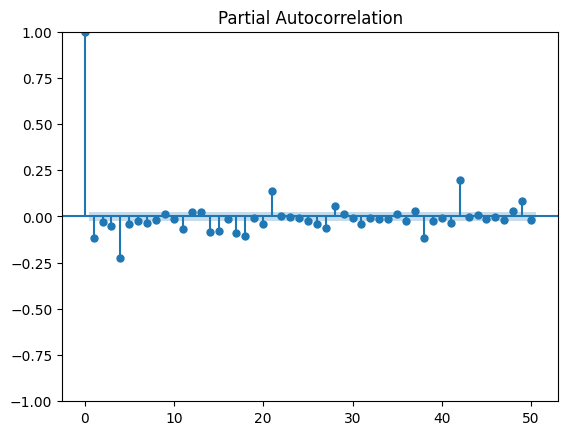

In [73]:
plot_pacf(df_prices_log_detrend_without_nans, alpha=0.5, lags=50);

In [74]:
df_cat_prices.structure_level_1.unique()

array([3, 1, 2])

Order: [3 1 2]


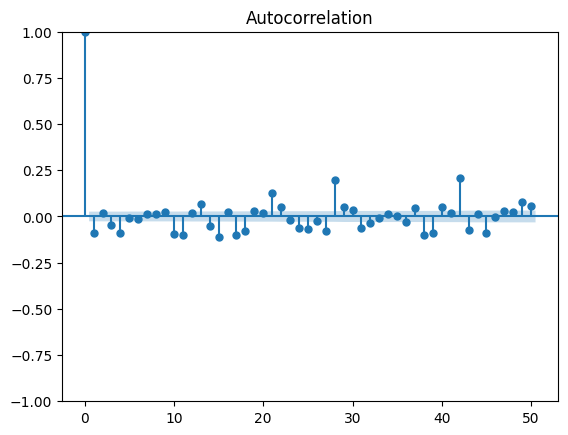

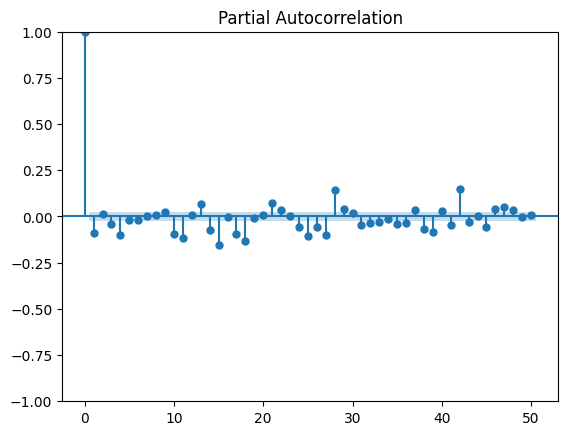

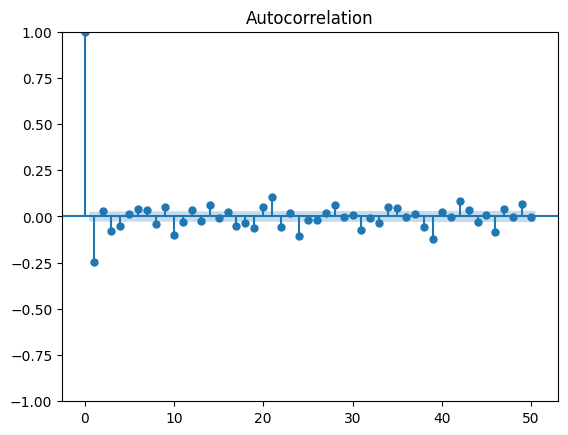

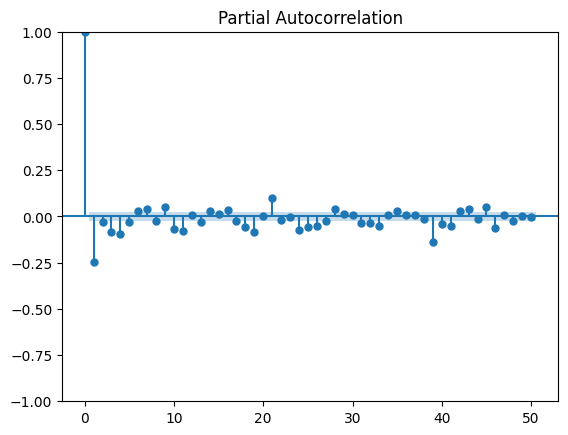

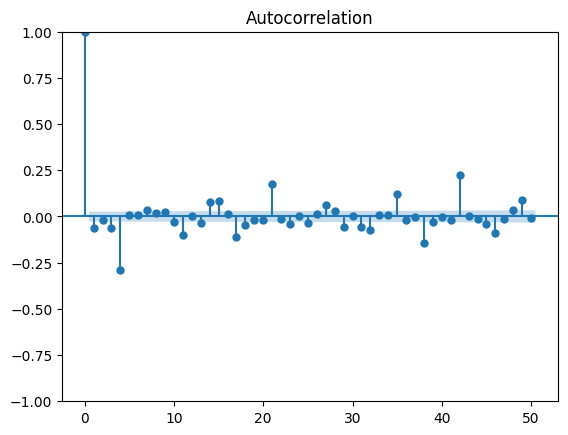

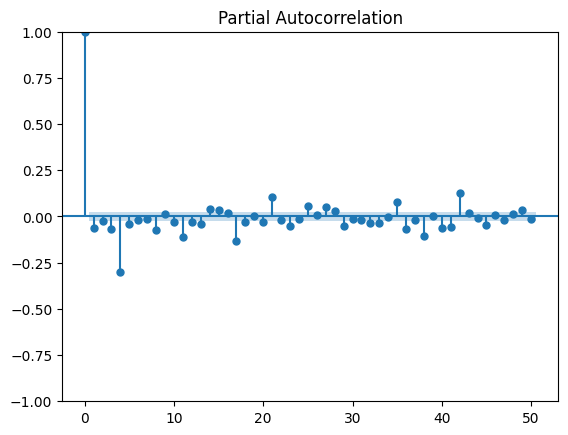

In [75]:
# per product category:
categories = df_cat_prices.structure_level_1.unique()
print(f"Order: {categories}")
for category in categories:
    df_category = df_cat_prices[df_cat_prices.structure_level_1 == category].groupby('time_key').agg({'price_final': 'mean'})
    df_category_log = df_category.map(np.log)
    df_category_log_detrend = df_category_log.diff()
    df_category_log_detrend_without_nans = df_category_log_detrend.dropna()
    plot_acf(df_category_log_detrend_without_nans, alpha=0.5, lags=50);
    plot_pacf(df_category_log_detrend_without_nans, alpha=0.5, lags=50);

Order: ['chain' 'competitorA' 'competitorB']


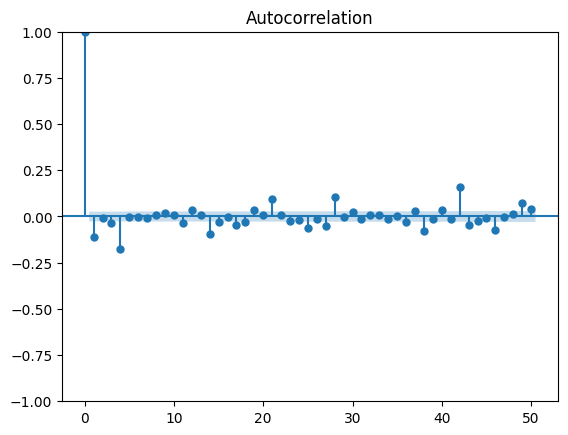

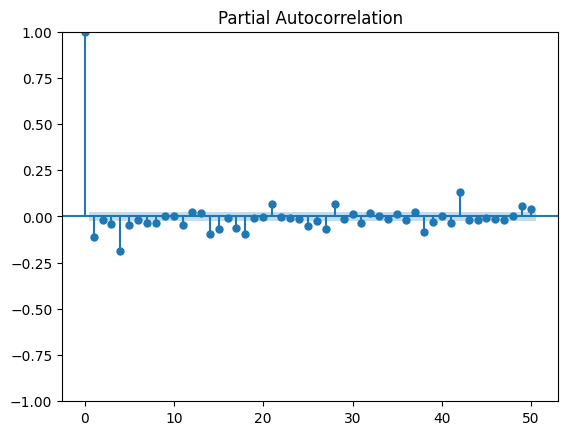

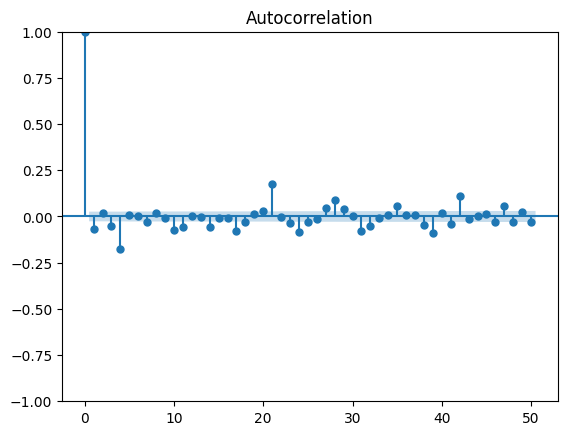

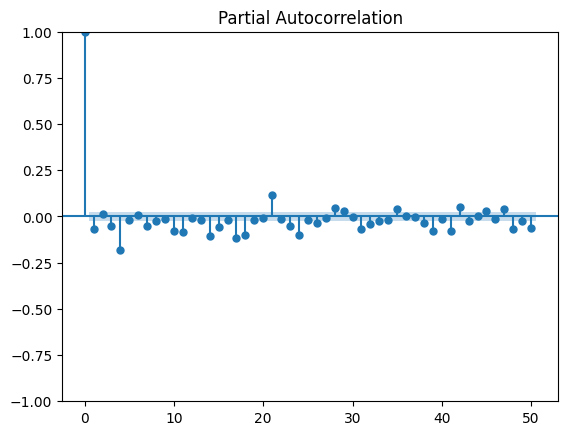

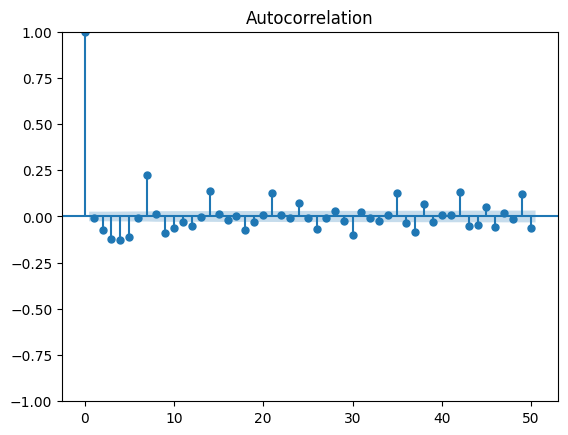

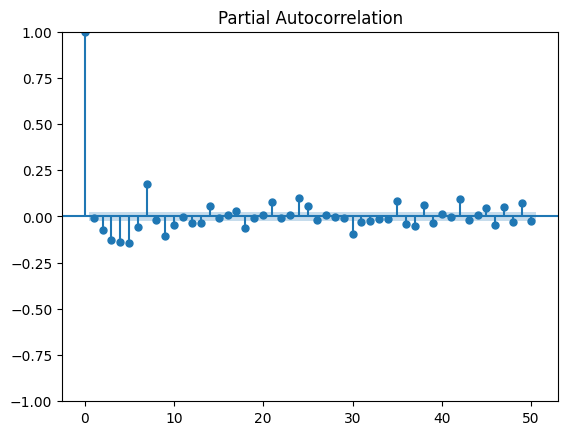

In [76]:
# per competitor:
competitors = df_cat_prices.competitor.unique()
print(f"Order: {competitors}")
for competitor in competitors:
    df_competitor = df_cat_prices[df_cat_prices.competitor == competitor].groupby('time_key').agg({'price_final': 'mean'})
    df_competitor_log = df_competitor.map(np.log)
    df_competitor_log_detrend = df_competitor_log.diff()
    df_competitor_log_detrend_without_nans = df_competitor_log_detrend.dropna()
    plot_acf(df_competitor_log_detrend_without_nans, alpha=0.5, lags=50);
    plot_pacf(df_competitor_log_detrend_without_nans, alpha=0.5, lags=50);

Conclusions:
* there seems to be a weekly seasonality, even though it is only clear/as expected in competitorB (7, 14, 28, 35, 42 days, diminuishing)
* overall (in total, and per product, and I believe chain) there is clear mark on the 6 weeks/42 days (the answer, of course)
* overall, it can be observed relation with the day before, 4 days before, 7, 14, 28, 35 and, a lot, 42 days before

## 3.3. Impact of promotional campaigns

In [77]:
df_campaigns.head()

,competitor,start_date,end_date,chain_campaign
0,chain,2024-08-12,2024-08-18,C2
1,competitorA,2023-09-22,2023-09-25,A2
2,chain,2024-09-23,2024-09-29,C1
3,chain,2024-04-08,2024-04-14,C1
4,competitorA,2023-10-20,2023-10-23,A2


In [78]:
df_product_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000


In [79]:
# Make the db in memory
conn = sqlite3.connect(':memory:')
# Write the tables
df_campaigns.to_sql('campaigns', conn, index=False)
df_product_prices.to_sql('product_prices', conn, index=False)
# query
qry = '''
    SELECT  product_prices.competitor,
            product_prices.time_key,
            campaigns.start_date,
            campaigns.end_date,
            product_prices.sku,
            product_prices.price_final
    FROM    product_prices
    LEFT JOIN campaigns ON product_prices.competitor = campaigns.competitor
    AND       (product_prices.time_key BETWEEN campaigns.start_date AND campaigns.end_date)
    '''
df_prices_campaigns = pd.read_sql_query(qry, conn)

In [80]:
df_prices_campaigns.head()

,competitor,time_key,start_date,end_date,sku,price_final
0,chain,2024-03-12 00:00:00,2024-03-11 00:00:00,2024-03-17 00:00:00,2056,21.700000
1,chain,2023-06-21 00:00:00,None,None,4435,13.709432
2,competitorA,2023-03-03 00:00:00,2023-03-03 00:00:00,2023-03-05 00:00:00,1951,39.231608
3,chain,2024-06-05 00:00:00,None,None,2135,41.477667
4,chain,2023-05-29 00:00:00,2023-05-23 00:00:00,2023-05-29 00:00:00,3949,51.900000


In [81]:
df_prices_campaigns.isna().sum()

competitor           0
time_key             0
start_date     1823416
end_date       1823416
sku                  0
price_final          0
dtype: int64

In [82]:
df_prices_campaigns =  df_prices_campaigns[df_prices_campaigns.competitor != 'competitorB']

In [83]:
df_prices_campaigns.isna().sum()

competitor           0
time_key             0
start_date     1554693
end_date       1554693
sku                  0
price_final          0
dtype: int64

In [84]:
df_prices_campaigns['is_active_campaign'] = df_prices_campaigns['start_date'].notnull()

In [85]:
df_prices_campaigns.head()

,competitor,time_key,start_date,end_date,sku,price_final,is_active_campaign
0,chain,2024-03-12 00:00:00,2024-03-11 00:00:00,2024-03-17 00:00:00,2056,21.700000,True
1,chain,2023-06-21 00:00:00,None,None,4435,13.709432,False
2,competitorA,2023-03-03 00:00:00,2023-03-03 00:00:00,2023-03-05 00:00:00,1951,39.231608,True
3,chain,2024-06-05 00:00:00,None,None,2135,41.477667,False
4,chain,2023-05-29 00:00:00,2023-05-23 00:00:00,2023-05-29 00:00:00,3949,51.900000,True


In [86]:
df_cat_campaigns = df_prices_campaigns.merge(df_prod_structure, left_on='sku', right_index=True)

In [87]:
df_cat1_campaigns = df_cat_campaigns.groupby(['structure_level_1', 'competitor', 'is_active_campaign']).agg({'price_final': 'mean'})

In [88]:
df_cat1_campaigns_diff = df_cat1_campaigns.unstack()
df_cat1_campaigns_diff['diff'] = df_cat1_campaigns_diff[('price_final', False)] - df_cat1_campaigns_diff[('price_final', True)]

In [89]:
df_cat1_campaigns_diff

price_final                 diff
is_active_campaign                  False       True          
structure_level_1 competitor                                  
1                 chain         45.554506  45.662439 -0.107933
                  competitorA   45.708944  45.617116  0.091828
2                 chain         57.856402  57.504928  0.351474
                  competitorA   53.870655  53.330763  0.539893
3                 chain         52.640250  52.690497 -0.050247
                  competitorA   46.524332  46.229116  0.295216

In [90]:
df_cat1_campaigns_diff['diff'].describe()

count    6.000000
mean     0.186705
std      0.251246
min     -0.107933
25%     -0.014728
50%      0.193522
75%      0.337409
max      0.539893
Name: diff, dtype: float64

<Axes: xlabel='structure_level_1,competitor'>

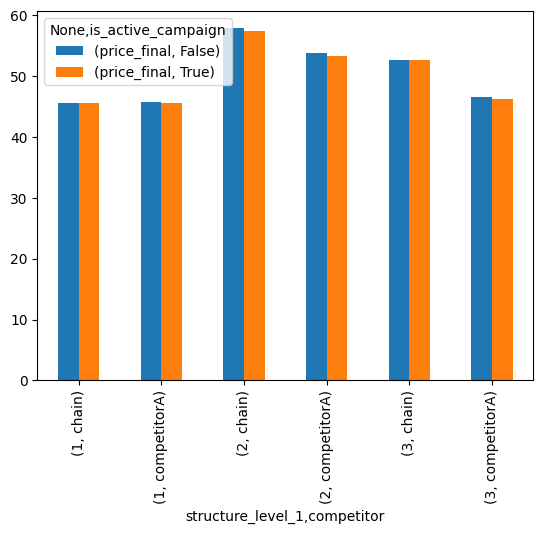

In [91]:
df_cat1_campaigns.unstack().plot.bar()

In [92]:
df_cat2_campaigns = df_cat_campaigns.groupby(['structure_level_2', 'competitor', 'is_active_campaign']).agg({'price_final': 'mean'})

In [93]:
df_cat2_campaigns_diff = df_cat2_campaigns.unstack()
df_cat2_campaigns_diff['diff'] = df_cat2_campaigns_diff[('price_final', False)] - df_cat2_campaigns_diff[('price_final', True)]

In [94]:
df_cat2_campaigns_diff['diff_rel'] = abs(df_cat2_campaigns_diff['diff']) / df_cat2_campaigns_diff[('price_final', False)]

In [95]:
df_cat2_campaigns_diff.head()

price_final                 diff  diff_rel
is_active_campaign                  False       True                    
structure_level_2 competitor                                            
101               chain         61.458703  61.800919 -0.342216  0.005568
                  competitorA   55.309113  55.003621  0.305492  0.005523
102               chain         41.941765  41.947530 -0.005764  0.000137
                  competitorA   42.654026  42.201850  0.452175  0.010601
103               chain         40.349919  40.546398 -0.196479  0.004869

In [96]:
df_cat2_campaigns_diff['diff'].describe()

count    26.000000
mean      0.381809
std       0.909292
min      -0.910096
25%      -0.093803
50%       0.136211
75%       0.488171
max       3.213766
Name: diff, dtype: float64

In [97]:
df_cat2_campaigns_diff['diff_rel'].describe()

count    26.000000
mean      0.010497
std       0.013386
min       0.000137
25%       0.003304
50%       0.005546
75%       0.010863
max       0.064148
Name: diff_rel, dtype: float64

<Axes: xlabel='structure_level_2,competitor'>

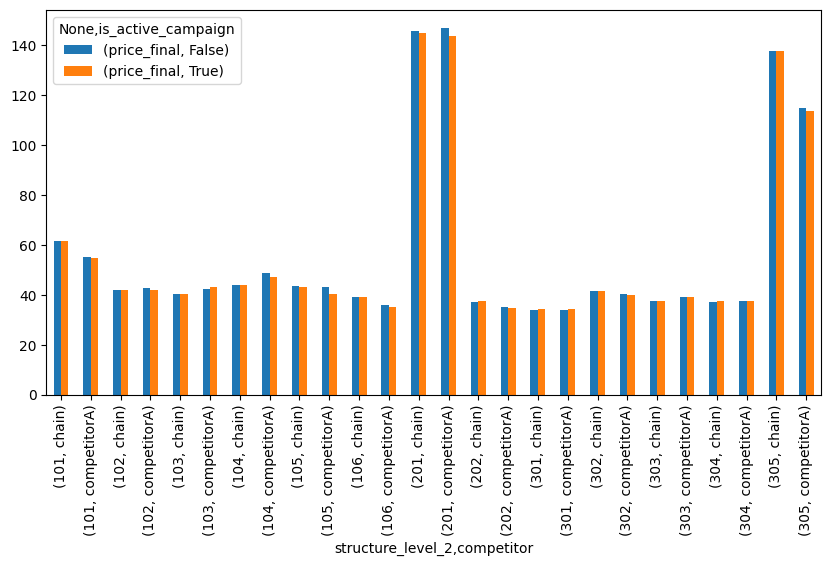

In [98]:
df_cat2_campaigns.unstack().plot.bar(figsize=(10, 5))

<Axes: xlabel='structure_level_2,competitor'>

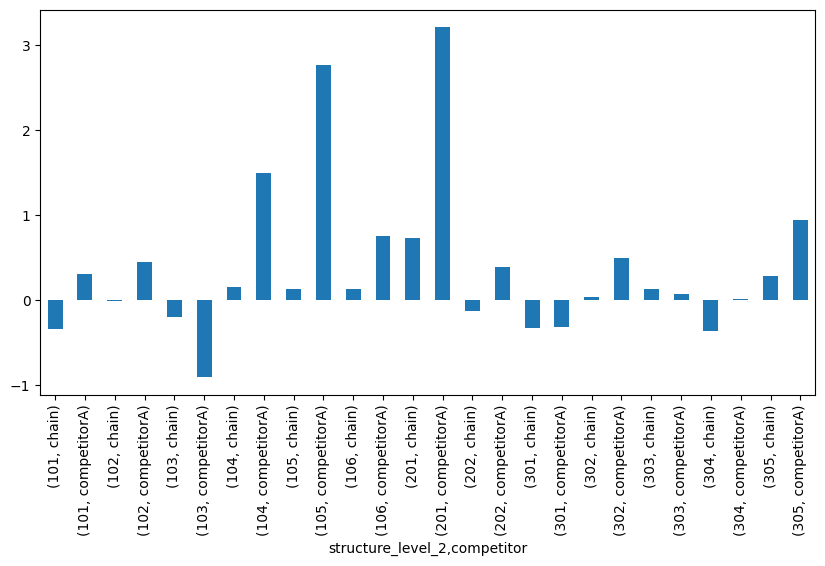

In [99]:
df_cat2_campaigns_diff['diff'].plot.bar(figsize=(10, 5))

<Axes: xlabel='structure_level_2,competitor'>

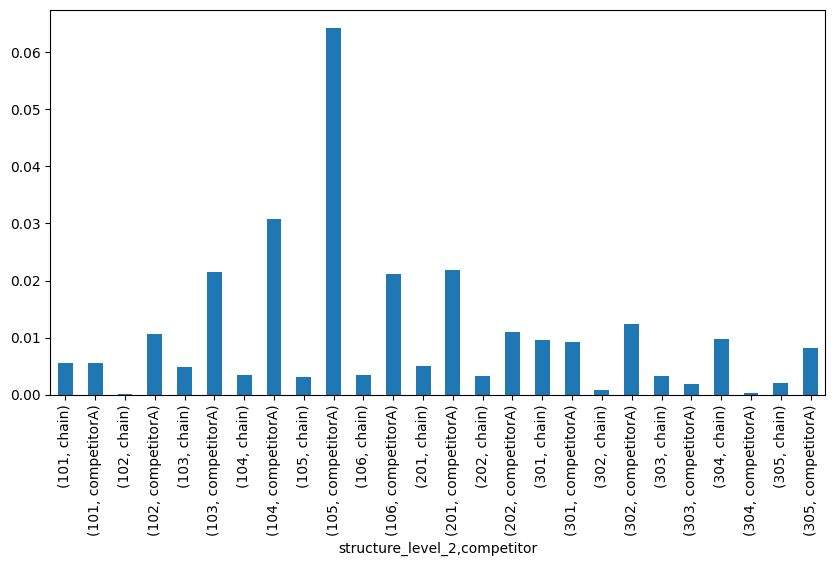

In [100]:
df_cat2_campaigns_diff['diff_rel'].plot.bar(figsize=(10, 5))

Conclusion: having an active campaign actually doesn't affect the prices much... they are pretty much the same

## 3.4. Impact of demand
Which came first, the chicken or the egg? Do prices lower because demand decreases, or does demand increase because prices lower?

In [101]:
df_prod_structure_sales.head()

,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,time_key,quantity
0,3020206,30202,302,3,3111,2023-06-18,18.6840
1,3020608,30206,302,3,3278,2024-07-31,396.1008
2,3020809,30208,302,3,3603,2023-08-07,6.2280
3,3020608,30206,302,3,4604,2023-01-31,27.4032
4,3040808,30408,304,3,3041,2023-09-06,6.2280


In [102]:
df_product_prices_chain = df_product_prices[df_product_prices.competitor == 'chain']

In [103]:
df_product_prices_chain.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000
6,3302,2024-04-27,chain,39.75,0.0000,0,NaN,39.750000


In [104]:
df_sales_prices = df_product_prices_chain.merge(df_prod_structure_sales, on=['time_key', 'sku'])

In [105]:
df_sales_prices_simplified = df_sales_prices.drop(columns=['sku', 'time_key', 'competitor', 'pvp_was', 'discount', 'flag_promo', 'leaflet', 'structure_level_4', 'structure_level_3'])

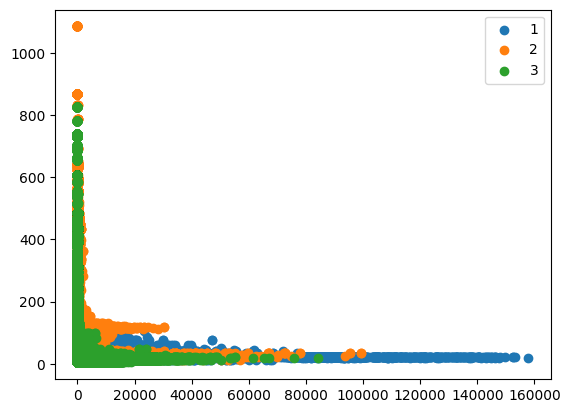

In [106]:
# plot lines plt.plot(x, y)
structures = [1, 2, 3]
for structure in structures:
    df_plot = df_sales_prices_simplified[df_sales_prices_simplified.structure_level_1 == structure]
    plt.scatter(df_plot['quantity'], df_plot['price_final'], label = structure)
plt.legend()
plt.show()

In [107]:
structures = df_sales_prices_simplified.structure_level_2.unique()
structures.sort()
structures

array([101, 102, 103, 104, 105, 106, 201, 202, 301, 302, 303, 304, 305])

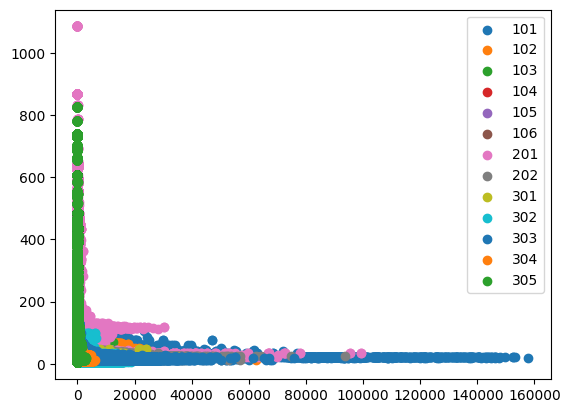

In [108]:
for structure in structures:
    df_plot = df_sales_prices_simplified[df_sales_prices_simplified.structure_level_2 == structure]
    plt.scatter(df_plot['quantity'], df_plot['price_final'], label = structure)
plt.legend()
plt.show()

Behold - more expensive items are purchased less than cheaper ones. Who could have known. This is also due to the product's nature (after all, one needs less garden tables than toilet paper).

# 4. Business questions

## 4.1. Average discount per competitor across different product categories

In [111]:
df_cat_prices = df_product_prices.merge(df_prod_structure, left_on='sku', right_index=True)
df_cat_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000,3021101,30211,302,3
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432,3030708,30307,303,3
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608,3020806,30208,302,3
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667,3010801,30108,301,3
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000,1010407,10104,101,1


In [198]:
df_prod_discounts = df_cat_prices.groupby(['structure_level_2', 'sku', 'competitor']).agg({'pvp_was': 'mean', 'discount': 'mean', 'price_final': 'mean'})

In [199]:
df_prod_discounts.head()

pvp_was  discount  price_final
structure_level_2 sku  competitor                                   
101               1132 chain        34.540000  0.000000    34.540000
                  1136 chain        60.580000  0.080240    55.719061
                       competitorA  67.516000  0.114514    59.585886
                  1156 chain        51.900000  0.023886    50.660331
                  1186 chain        65.104638  0.000000    65.104638

In [200]:
df_prod_discounts_all = df_prod_discounts.unstack(level='competitor').dropna()

In [212]:
# have to unstack to create the NaNs for the product, competitor pairs we have no information about

In [201]:
df_prod_discounts_all.head()

pvp_was                          discount  \
competitor                  chain competitorA competitorB     chain   
structure_level_2 sku                                                 
101               1254  71.446544   58.498785   57.118913  0.006794   
                  1297  61.631757   70.620423   68.870312  0.005980   
                  1378  31.070000   32.800000   32.800000  0.000000   
                  1379  69.250000   69.250000   61.768333  0.048096   
                  1384  36.985932   36.194323   36.369827  0.000000   

                                               price_final              \
competitor             competitorA competitorB       chain competitorA   
structure_level_2 sku                                                    
101               1254    0.000000    0.108698   70.999627   58.498785   
                  1297    0.028125    0.142523   61.261253   68.599936   
                  1378    0.029624    0.000000   31.070000   31.828333   
                  1379    0.000000    0.036808   65.919352   69.250000   
                  1384    0.000000    0.000000   36.985932   36.194323   

                                    
competitor             competitorB  
structure_level_2 sku               
101               1254   50.912267  
                  1297   59.000601  
                  1378   32.800000  
                  1379   59.589648  
                  1384   36.369827

In [213]:
# stacking again - using future_stack flag to avoid a warning

In [214]:
df_prod_discounts = df_prod_discounts_all.stack(future_stack=True)

In [216]:
df_level2_discounts = df_prod_discounts.groupby(['structure_level_2', 'competitor']).agg({'pvp_was': ['mean', 'std'], 'discount': ['mean', 'std'], 'price_final': ['mean', 'std']})

In [217]:
df_level2_discount = df_level2_discounts[[('discount', 'mean')]]
df_level2_discount.columns = df_level2_discount.columns.droplevel()
df_level2_discount = df_level2_discount.rename(columns={'mean': 'discount_avg'})

In [218]:
df_level2_discount.head()

discount_avg
structure_level_2 competitor               
101               chain            0.011914
                  competitorA      0.043255
                  competitorB      0.027095
102               chain            0.008989
                  competitorA      0.015600

<Axes: xlabel='structure_level_2'>

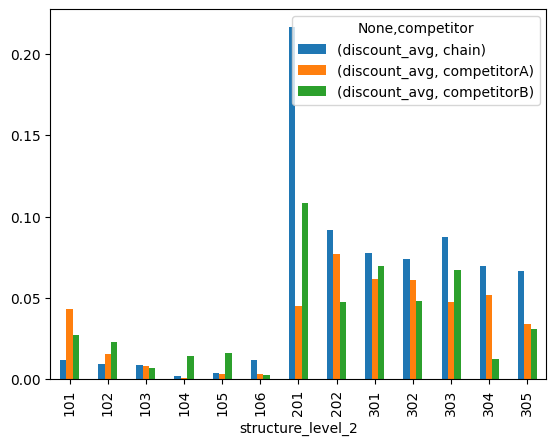

In [219]:
df_level2_discount.unstack().plot.bar()

<Axes: xlabel='structure_level_2'>

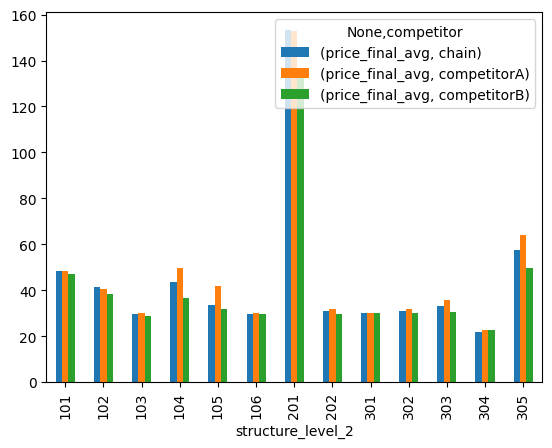

In [220]:
df_level2_pricefinal = df_level2_discounts[[('price_final', 'mean')]]
df_level2_pricefinal.columns = df_level2_pricefinal.columns.droplevel()
df_level2_pricefinal = df_level2_pricefinal.rename(columns={'mean': 'price_final_avg'})
df_level2_pricefinal.unstack().plot.bar()

Below is the old method (first approach, without removing the products where we don't have information for all competitors):

In [112]:
df_level1_discounts = df_cat_prices.groupby(['structure_level_1', 'competitor']).agg({'pvp_was': ['mean', 'std'], 'discount': ['mean', 'std'], 'price_final': ['mean', 'std']})
df_level1_discounts

pvp_was             discount            \
                                    mean        std      mean       std   
structure_level_1 competitor                                              
1                 chain        46.209144  35.785185  0.012070  0.051277   
                  competitorA  46.730499  38.583629  0.022359  0.073722   
                  competitorB  37.847010  19.943243  0.015969  0.059899   
2                 chain        67.527773  91.417506  0.097996  0.140484   
                  competitorA  57.187307  69.685035  0.068745  0.123053   
                  competitorB  55.485144  93.001423  0.031681  0.088431   
3                 chain        58.258637  66.972200  0.090757  0.138911   
                  competitorA  49.720212  51.247224  0.059059  0.119715   
                  competitorB  29.071205  23.034037  0.020706  0.071360   

                              price_final             
                                     mean        std  
structure_level_1 competitor                          
1                 chain         45.614770  35.475261  
                  competitorA   45.692675  38.364867  
                  competitorB   37.130441  19.478379  
2                 chain         57.660759  70.657936  
                  competitorA   53.701922  67.616145  
                  competitorB   50.911203  76.139587  
3                 chain         52.668304  63.149291  
                  competitorA   46.445276  49.437628  
                  competitorB   28.187590  22.273804

In [113]:
df_level2_discounts = df_cat_prices.groupby(['structure_level_2', 'competitor']).agg({'pvp_was': ['mean', 'std'], 'discount': ['mean', 'std'], 'price_final': ['mean', 'std']})
df_level2_discounts

pvp_was              discount            \
                                     mean         std      mean       std   
structure_level_2 competitor                                                
101               chain         62.558577   52.337279  0.013171  0.049779   
                  competitorA   57.343989   44.874133  0.041521  0.095979   
                  competitorB   47.314187   21.694581  0.024193  0.073389   
102               chain         42.274181   18.598139  0.007636  0.042223   
                  competitorA   43.095513   19.399771  0.014200  0.063533   
                  competitorB   38.875069   17.858950  0.018578  0.066663   
103               chain         41.196962   34.451864  0.016971  0.062623   
                  competitorA   43.618551   47.459526  0.020125  0.069248   
                  competitorB   30.953522   19.974202  0.008623  0.039568   
104               chain         44.187197   17.091961  0.002404  0.018163   
                  competitorA   48.396194   19.623301  0.002497  0.025430   
                  competitorB   35.873308    8.919468  0.014055  0.055848   
105               chain         43.538116   16.474878  0.003311  0.021568   
                  competitorA   42.547890   18.251901  0.003243  0.022802   
                  competitorB   31.470906    9.055663  0.010609  0.047985   
106               chain         39.334843   20.038317  0.005895  0.027881   
                  competitorA   36.122268    9.908502  0.011085  0.045150   
                  competitorB   28.083871    5.210904  0.003992  0.029287   
201               chain        184.302242  160.591055  0.183936  0.150763   
                  competitorA  152.772285  124.460161  0.041531  0.096609   
                  competitorB  155.137107  160.427008  0.059388  0.127572   
202               chain         40.571050   21.413535  0.078158  0.130177   
                  competitorA   37.776443   21.548428  0.074271  0.127046   
                  competitorB   27.309635   14.721981  0.023847  0.071774   
301               chain         37.826913   14.230276  0.083502  0.137822   
                  competitorA   36.207226   12.613559  0.050823  0.117627   
                  competitorB   31.785450   13.636306  0.020883  0.071903   
302               chain         46.391898   26.801807  0.087269  0.138183   
                  competitorA   43.678050   23.897160  0.061482  0.123486   
                  competitorB   25.213179   18.022746  0.013967  0.058025   
303               chain         43.610501   22.648384  0.113375  0.152631   
                  competitorA   42.547739   23.874793  0.062039  0.122890   
                  competitorB   29.648928   19.799070  0.032136  0.090481   
304               chain         42.431029   18.860270  0.110364  0.145553   
                  competitorA   40.915100   19.597698  0.076075  0.127506   
                  competitorB   24.285003    8.099647  0.013419  0.045097   
305               chain        146.479628  141.560000  0.049351  0.090989   
                  competitorA  118.659765  129.673115  0.029317  0.072161   
                  competitorB   72.241951   74.885252  0.018513  0.058831   

                              price_final              
                                     mean         std  
structure_level_2 competitor                           
101               chain         61.649291   51.673898  
                  competitorA   55.222167   44.553295  
                  competitorB   46.106155   21.367290  
102               chain         41.944984   18.534381  
                  competitorA   42.520878   19.483064  
                  competitorB   38.112973   17.633030  
103               chain         40.459802   34.314405  
                  competitorA   42.757618   47.387312  
                  competitorB   30.561746   19.331994  
104               chain         44.057515   16.999445  
                  competitorA   48.264609   19.627544  
               

Standard deviation is huge in comparison with the mean... not sure there is anything meaningful in here...

In [114]:
df_level3_discounts = df_cat_prices.groupby(['structure_level_3', 'competitor']).agg({'pvp_was': ['mean', 'std'], 'discount': ['mean', 'std'], 'price_final': ['mean', 'std']})
df_level3_discounts.head()

pvp_was             discount            \
                                    mean        std      mean       std   
structure_level_3 competitor                                              
10101             chain        47.729791  20.532059  0.011871  0.043088   
                  competitorA  41.697424   6.275070  0.039758  0.084210   
                  competitorB  39.238963   9.715958  0.014143  0.049137   
10102             chain        39.706206   8.489210  0.010147  0.038816   
                  competitorA  39.493177   8.569819  0.015443  0.058876   

                              price_final             
                                     mean        std  
structure_level_3 competitor                          
10101             chain         47.242487  20.745695  
                  competitorA   40.056977   7.105010  
                  competitorB   38.726385   9.900230  
10102             chain         39.307364   8.602372  
                  competitorA   38.875925   8.784118

In [115]:
df_level4_discounts = df_cat_prices.groupby(['structure_level_4', 'competitor']).agg({'pvp_was': ['mean', 'std'], 'discount': ['mean', 'std'], 'price_final': ['mean', 'std']})
df_level4_discounts.head()

pvp_was            discount            \
                                    mean       std      mean       std   
structure_level_4 competitor                                             
1010101           chain        39.607706  8.615206  0.011954  0.045646   
                  competitorA  43.094694  6.133061  0.040472  0.081809   
                  competitorB  39.238963  9.715958  0.014143  0.049137   
1010106           chain        44.180676  6.300451  0.008840  0.038090   
                  competitorA  47.765439  1.240357  0.031954  0.085590   

                              price_final            
                                     mean       std  
structure_level_4 competitor                         
1010101           chain         39.103997  8.638951  
                  competitorA   41.343222  6.873363  
                  competitorB   38.726385  9.900230  
1010106           chain         43.771661  6.394763  
                  competitorA   46.273488  4.553138

NaN in standard deviation means the group has only one element

In [116]:
df_level2_discount = df_level2_discounts[[('discount', 'mean')]]
df_level2_discount.columns = df_level2_discount.columns.droplevel()
df_level2_discount = df_level2_discount.rename(columns={'mean': 'discount_avg'})
df_level2_discount.head()

discount_avg
structure_level_2 competitor               
101               chain            0.013171
                  competitorA      0.041521
                  competitorB      0.024193
102               chain            0.007636
                  competitorA      0.014200

In [117]:
df_level2_discount.unstack().head()

discount_avg                        
competitor               chain competitorA competitorB
structure_level_2                                     
101                   0.013171    0.041521    0.024193
102                   0.007636    0.014200    0.018578
103                   0.016971    0.020125    0.008623
104                   0.002404    0.002497    0.014055
105                   0.003311    0.003243    0.010609

<Axes: xlabel='structure_level_2'>

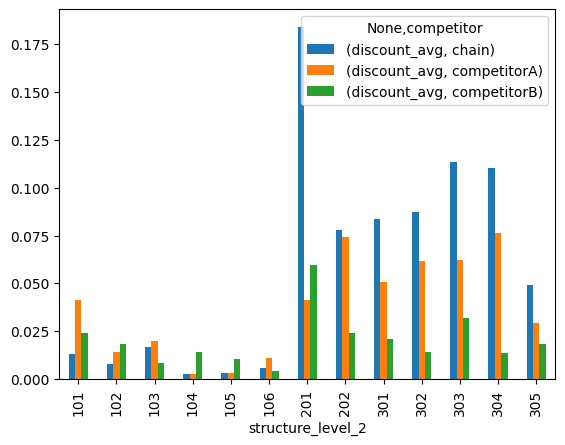

In [118]:
df_level2_discount.unstack().plot.bar()

<Axes: xlabel='structure_level_2'>

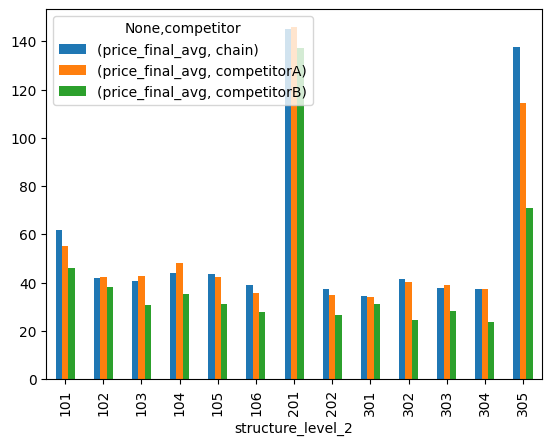

In [119]:
df_level2_pricefinal = df_level2_discounts[[('price_final', 'mean')]]
df_level2_pricefinal.columns = df_level2_pricefinal.columns.droplevel()
df_level2_pricefinal = df_level2_pricefinal.rename(columns={'mean': 'price_final_avg'})
df_level2_pricefinal.unstack().plot.bar()

In [120]:
df_level1_discount = df_level1_discounts[[('discount', 'mean')]]
df_level1_discount.columns = df_level1_discount.columns.droplevel()
df_level1_discount = df_level1_discount.rename(columns={'mean': 'discount_avg'})
df_level1_discount.head()

discount_avg
structure_level_1 competitor               
1                 chain            0.012070
                  competitorA      0.022359
                  competitorB      0.015969
2                 chain            0.097996
                  competitorA      0.068745

<Axes: xlabel='structure_level_1'>

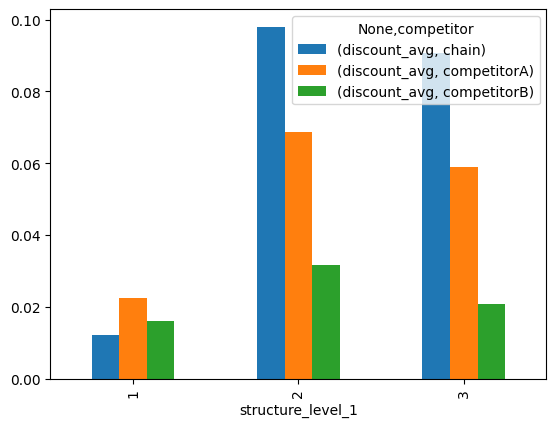

In [121]:
df_level1_discount.unstack().plot.bar()

<Axes: xlabel='structure_level_1'>

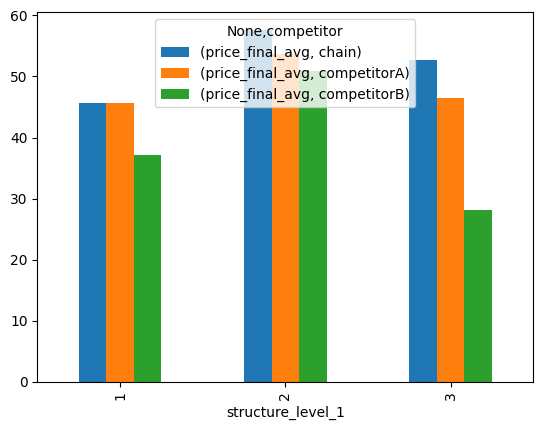

In [122]:
df_level1_pricefinal = df_level1_discounts[[('price_final', 'mean')]]
df_level1_pricefinal.columns = df_level1_pricefinal.columns.droplevel()
df_level1_pricefinal = df_level1_pricefinal.rename(columns={'mean': 'price_final_avg'})
df_level1_pricefinal.unstack().plot.bar()

Soo... if I am to conclude anything:
* every company applies more discounts to products from category 2 and 3, and less on products from category 1
* this difference is even more visible for the chain in question, where the difference is more remarkable
* however, due to differences in base price, they are often the most expensive one... and competitorB is always the cheapest

## 4.2. Level of promotional participation
Promotional participation quantifies the fraction of sales done from promotional products.

In [123]:
df_prod_structure_sales.head()

,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,time_key,quantity
0,3020206,30202,302,3,3111,2023-06-18,18.6840
1,3020608,30206,302,3,3278,2024-07-31,396.1008
2,3020809,30208,302,3,3603,2023-08-07,6.2280
3,3020608,30206,302,3,4604,2023-01-31,27.4032
4,3040808,30408,304,3,3041,2023-09-06,6.2280


In [124]:
df_product_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000


In [125]:
df_product_prices_chain = df_product_prices[df_product_prices.competitor == 'chain']

In [126]:
df_prod_prices_sales = pd.merge(df_product_prices_chain, df_prod_structure_sales, on=['time_key', 'sku'])

In [127]:
df_prod_prices_sales.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1,quantity
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000,3021101,30211,302,3,146.980800
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432,3030708,30307,303,3,198.050400
2,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667,3010801,30108,301,3,229.190400
3,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000,1010407,10104,101,1,4734.052272
4,2937,2023-04-05,chain,17.18,0.0000,0,NaN,17.180000,3020601,30206,302,3,280.260000


In [128]:
promo_participation = (df_prod_prices_sales[df_prod_prices_sales.flag_promo == 1].quantity.sum() / df_prod_prices_sales.quantity.sum()) * 100

In [129]:
promo_participation

np.float64(23.526700983397628)

Note:
* quantity is in different units for different products... also from my understanding it's often the weight... this way, denser products count more than lighter ones, which shouldn't be the case... that being said, this promotional participation value should be used with moderation.
* no way to calculate it for the competition, so cannot really compare it.

## 4.3. How pricing competitiveness varies in time

When discussing pricing competitiveness internally, we generally want to understand if prices at Retailz are higher than those at competitors.

In [130]:
df_cat_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000,3021101,30211,302,3
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432,3030708,30307,303,3
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608,3020806,30208,302,3
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667,3010801,30108,301,3
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000,1010407,10104,101,1


In [131]:
df_cat_prices_evolution = df_cat_prices.drop(columns=['pvp_was', 'discount', 'flag_promo', 'leaflet'])

In [132]:
df_product_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000


I was getting issues ahead, because there are "duplicate" entries with different value for leaflet

In [133]:
df_prod_prices_evolution = df_product_prices.drop(columns='leaflet')

In [134]:
df_prod_prices_evolution.shape

(3112100, 7)

In [135]:
df_prod_prices_evolution = df_prod_prices_evolution.drop_duplicates()

In [136]:
df_prod_prices_evolution.shape

(3040855, 7)

In [137]:
df_prod_prices_evolution = df_prod_prices_evolution.drop(columns=['pvp_was', 'discount', 'flag_promo'])
df_prod_prices_evolution = df_prod_prices_evolution.set_index(['time_key', 'sku', 'competitor'])
df_prod_prices_evolution = df_prod_prices_evolution.sort_index()

In [138]:
df_prod_prices_evolution.head()

price_final
time_key   sku  competitor             
2023-01-03 1615 chain          39.75000
           1618 chain          22.39000
           1624 chain          16.49000
           1625 chain          16.49000
           1626 chain          20.65032

In [139]:
np.where(df_prod_prices_evolution.index.duplicated())

(array([], dtype=int64),)

In [140]:
df_prod_prices_evolution.unstack(level='competitor')

price_final                        
competitor            chain competitorA competitorB
time_key   sku                                     
2023-01-03 1615   39.750000         NaN         NaN
           1618   22.390000         NaN         NaN
           1624   16.490000         NaN         NaN
           1625   16.490000         NaN         NaN
           1626   20.650320   18.919800         NaN
...                     ...         ...         ...
2024-10-28 4730   17.180625         NaN         NaN
           4732   31.070000   31.070000         NaN
           4733  101.542033   95.285136  101.538192
           4734   18.048690   24.990000         NaN
           4735   55.540000   55.370000         NaN

[1690384 rows x 3 columns]

In [141]:
df_prod_prices_evolution_all = df_prod_prices_evolution.unstack(level='competitor').dropna(subset=[('price_final','chain'), ('price_final','competitorA'), ('price_final','competitorB')])

In [142]:
df_prod_prices_evolution_all

price_final                        
competitor            chain competitorA competitorB
time_key   sku                                     
2023-01-03 1640   44.950000   46.690000   46.690000
           1642   39.750000   41.480000   34.540000
           1660   51.900000   47.730000   47.730000
           1663   51.900000   48.430000   48.430000
           1696   17.180000   17.180000   17.180000
...                     ...         ...         ...
2024-10-28 4666   65.776575   88.350000   65.776575
           4667   29.330000   29.330000   29.330000
           4706   18.050400   27.250000   18.050000
           4714   12.319830   30.900000   21.700000
           4733  101.542033   95.285136  101.538192

[213460 rows x 3 columns]

In [143]:
213460 / 1690384

0.12627899932796335

Yap, that's a huge reduction... only 87% of the data...

In [144]:
df_prod_prices_evolution_all['is_highest'] = (df_prod_prices_evolution_all[('price_final', 'chain')] > df_prod_prices_evolution_all[('price_final', 'competitorA')]) & (df_prod_prices_evolution_all[('price_final', 'chain')] > df_prod_prices_evolution_all[('price_final', 'competitorB')])

In [145]:
df_prod_prices_evolution_all['is_lowest'] = (df_prod_prices_evolution_all[('price_final', 'chain')] < df_prod_prices_evolution_all[('price_final', 'competitorA')]) & (df_prod_prices_evolution_all[('price_final', 'chain')] < df_prod_prices_evolution_all[('price_final', 'competitorB')])

In [146]:
df_prod_prices_evolution_all.head()

price_final                         is_highest is_lowest
competitor            chain competitorA competitorB                     
time_key   sku                                                          
2023-01-03 1640       44.95       46.69       46.69      False      True
           1642       39.75       41.48       34.54      False     False
           1660       51.90       47.73       47.73       True     False
           1663       51.90       48.43       48.43       True     False
           1696       17.18       17.18       17.18      False     False

In [147]:
is_highest = (df_prod_prices_evolution_all['is_highest'].sum() / df_prod_prices_evolution_all.shape[0]) * 100
is_lowest = (df_prod_prices_evolution_all['is_lowest'].sum() / df_prod_prices_evolution_all.shape[0]) * 100
f"Retailz is the most expensive store for a given product in a given moment in time {is_highest}% of the time, and the cheapest {is_lowest}% of the time"

'Retailz is the most expensive store for a given product in a given moment in time 18.879883818982478% of the time, and the cheapest 13.468565539211093% of the time'

In [148]:
df_prod_prices_evolution_all.columns

MultiIndex([('price_final',       'chain'),
            ('price_final', 'competitorA'),
            ('price_final', 'competitorB'),
            ( 'is_highest',            ''),
            (  'is_lowest',            '')],
           names=[None, 'competitor'])

In [149]:
df_prod_prices_evolution_extremes =  df_prod_prices_evolution_all.groupby('time_key').agg({('is_highest', ''): 'sum', ('is_lowest', ''): 'sum', ('price_final', 'chain'): 'count'})

In [150]:
df_prod_prices_evolution_extremes.columns = df_prod_prices_evolution_extremes.columns.droplevel(level='competitor')

In [151]:
df_prod_prices_evolution_extremes = df_prod_prices_evolution_extremes.rename(columns={'price_final': 'count'})

In [152]:
df_prod_prices_evolution_extremes['is_highest_%'] = (df_prod_prices_evolution_extremes['is_highest'] / df_prod_prices_evolution_extremes['count']) * 100
df_prod_prices_evolution_extremes['is_lowest_%'] = (df_prod_prices_evolution_extremes['is_lowest'] / df_prod_prices_evolution_extremes['count']) * 100

In [153]:
df_prod_prices_evolution_extremes.head()

,is_highest,is_lowest,count,is_highest_%,is_lowest_%
time_key,,,,,
2023-01-03,62,44,357,17.366947,12.324930
2023-01-04,51,45,342,14.912281,13.157895
2023-01-05,50,48,342,14.619883,14.035088
2023-01-06,48,53,343,13.994169,15.451895
2023-01-07,48,51,344,13.953488,14.825581


In [154]:
df_prod_prices_evolution_extremes[['is_highest_%', 'is_lowest_%']].loc['01/03/2023':'12/31/2023']

,is_highest_%,is_lowest_%
time_key,,
2023-01-03,17.366947,12.324930
2023-01-04,14.912281,13.157895
2023-01-05,14.619883,14.035088
2023-01-06,13.994169,15.451895
2023-01-07,13.953488,14.825581
...,...,...
2023-12-27,24.104235,9.771987
2023-12-28,27.062706,7.260726
2023-12-29,27.483444,6.953642


<Axes: xlabel='time_key'>

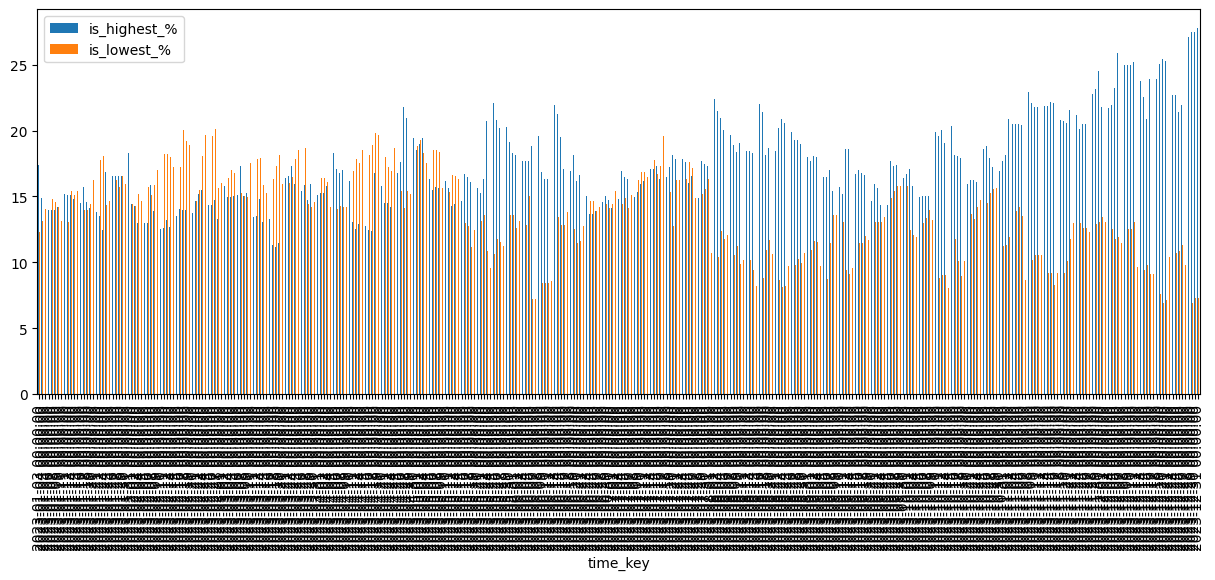

In [155]:
df_prod_prices_evolution_extremes[['is_highest_%', 'is_lowest_%']].loc['01/03/2023':'12/31/2023'].plot.bar(figsize=(15, 5))

In [156]:
df_prod_prices_evolution_extremes['year_month'] = df_prod_prices_evolution_extremes.index.values
df_prod_prices_evolution_extremes['year_month'] = df_prod_prices_evolution_extremes['year_month'].apply(lambda row: str(row)[0:7])

In [157]:
# not the ideal way of doing it I know... but I came up with it before transforming time_key into datetime

In [158]:
df_prod_prices_evolution_extremes.head()

,is_highest,is_lowest,count,is_highest_%,is_lowest_%,year_month
time_key,,,,,,
2023-01-03,62,44,357,17.366947,12.324930,2023-01
2023-01-04,51,45,342,14.912281,13.157895,2023-01
2023-01-05,50,48,342,14.619883,14.035088,2023-01
2023-01-06,48,53,343,13.994169,15.451895,2023-01
2023-01-07,48,51,344,13.953488,14.825581,2023-01


In [159]:
df_prod_prices_evolution_monthly = df_prod_prices_evolution_extremes.groupby('year_month').agg({'is_highest': 'sum', 'is_lowest': 'sum', 'count': 'sum'})

In [160]:
df_prod_prices_evolution_monthly['is_highest_%'] = (df_prod_prices_evolution_monthly['is_highest'] / df_prod_prices_evolution_monthly['count']) * 100
df_prod_prices_evolution_monthly['is_lowest_%'] = (df_prod_prices_evolution_monthly['is_lowest'] / df_prod_prices_evolution_monthly['count']) * 100

In [161]:
df_prod_prices_evolution_monthly

,is_highest,is_lowest,count,is_highest_%,is_lowest_%
year_month,,,,,
2023-01,1523,1494,9954,15.300382,15.009042
2023-02,1355,1685,9806,13.818071,17.183357
2023-03,1599,1802,10939,14.617424,16.473169
2023-04,1744,1793,10875,16.036782,16.487356
2023-05,1994,1670,11445,17.422455,14.591525
2023-06,1769,1250,10385,17.034184,12.036591
2023-07,1600,1560,9782,16.356573,15.947659
2023-08,1955,1015,9919,19.709648,10.232886
2023-09,1578,1168,9579,16.473536,12.193340


<Axes: xlabel='year_month'>

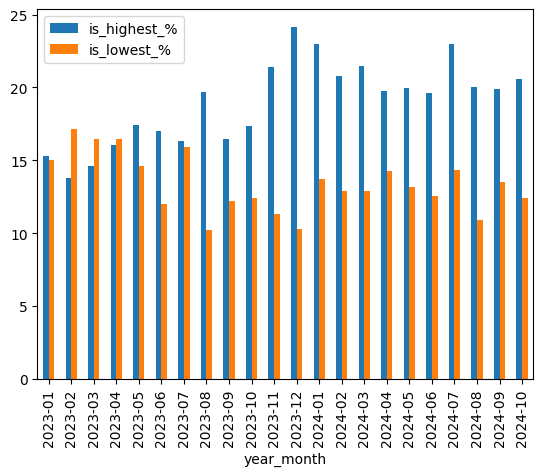

In [162]:
df_prod_prices_evolution_monthly[['is_highest_%', 'is_lowest_%']].plot.bar()

How I look at it:
* First half of 2023, fairly balanced
* Second half of 2023 feels like a transition period
* 2024 clearly more common to have higher prices than cheaper ones
</br>

In other words: seems like Retailz was more price competitive in the beginning of 2023 than in 2024.

Ok... while there is some sense in focusing on the sku's where I have all information, that has not been the strategy so far... should have som consistency

In [165]:
df_cat_prices_evolution.head()

,sku,time_key,competitor,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
0,2056,2024-03-12,chain,21.700000,3021101,30211,302,3
1,4435,2023-06-21,chain,13.709432,3030708,30307,303,3
2,1951,2023-03-03,competitorA,39.231608,3020806,30208,302,3
3,2135,2024-06-05,chain,41.477667,3010801,30108,301,3
4,3949,2023-05-29,chain,51.900000,1010407,10104,101,1


In [170]:
df_cat2_prices_evolution = df_cat_prices_evolution.groupby(['time_key', 'structure_level_2', 'competitor']).agg({'price_final': 'mean'})
df_cat2_prices_evolution = df_cat2_prices_evolution.sort_index()

In [172]:
df_cat2_prices_evolution_all = df_cat2_prices_evolution.unstack(level='competitor')

In [173]:
df_cat2_prices_evolution_all['is_highest'] = (df_cat2_prices_evolution_all[('price_final', 'chain')] > df_cat2_prices_evolution_all[('price_final', 'competitorA')]) & (df_cat2_prices_evolution_all[('price_final', 'chain')] > df_cat2_prices_evolution_all[('price_final', 'competitorB')])
df_cat2_prices_evolution_all['is_lowest'] = (df_cat2_prices_evolution_all[('price_final', 'chain')] < df_cat2_prices_evolution_all[('price_final', 'competitorA')]) & (df_cat2_prices_evolution_all[('price_final', 'chain')] < df_cat2_prices_evolution_all[('price_final', 'competitorB')])

In [176]:
is_highest = (df_cat2_prices_evolution_all['is_highest'].sum() / df_cat2_prices_evolution_all.shape[0]) * 100
is_lowest = (df_cat2_prices_evolution_all['is_lowest'].sum() / df_cat2_prices_evolution_all.shape[0]) * 100
f"Retailz is the most expensive store for a given product in a given moment in time {is_highest}% of the time, and the cheapest {is_lowest}% of the time"

'Retailz is the most expensive store for a given product in a given moment in time 57.50144592249855% of the time, and the cheapest 1.8970503181029497% of the time'

In [180]:
df_cat2_prices_evolution_all.head()

price_final                         is_highest  \
competitor                         chain competitorA competitorB              
time_key   structure_level_2                                                  
2023-01-03 101                 66.031935   57.852275   49.256945       True   
           102                 41.664949   44.527031   35.718777      False   
           103                 45.054016   45.909702   33.041379      False   
           104                 40.537273   39.674286   34.453080       True   
           105                 42.704074   36.709098   29.775351       True   

                             is_lowest  
competitor                              
time_key   structure_level_2            
2023-01-03 101                   False  
           102                   False  
           103                   False  
           104                   False  
           105                   False

In [177]:
df_cat2_prices_evolution_extremes =  df_cat2_prices_evolution_all.groupby('time_key').agg({('is_highest', ''): 'sum', ('is_lowest', ''): 'sum', ('price_final', 'chain'): 'count'})
df_cat2_prices_evolution_extremes.columns = df_cat2_prices_evolution_extremes.columns.droplevel(level='competitor')
df_cat2_prices_evolution_extremes = df_cat2_prices_evolution_extremes.rename(columns={'price_final': 'count'})

In [178]:
df_cat2_prices_evolution_extremes['is_highest_%'] = (df_cat2_prices_evolution_extremes['is_highest'] / df_cat2_prices_evolution_extremes['count']) * 100
df_cat2_prices_evolution_extremes['is_lowest_%'] = (df_cat2_prices_evolution_extremes['is_lowest'] / df_cat2_prices_evolution_extremes['count']) * 100

In [179]:
df_cat2_prices_evolution_extremes.head()

,is_highest,is_lowest,count,is_highest_%,is_lowest_%
time_key,,,,,
2023-01-03,11,0,13,84.615385,0.0
2023-01-04,11,0,13,84.615385,0.0
2023-01-05,11,0,13,84.615385,0.0
2023-01-06,9,0,13,69.230769,0.0
2023-01-07,10,0,13,76.923077,0.0


In [181]:
df_cat2_prices_evolution_extremes['year_month'] = df_cat2_prices_evolution_extremes.index.values
df_cat2_prices_evolution_extremes['year_month'] = df_cat2_prices_evolution_extremes['year_month'].apply(lambda row: str(row)[0:7])

In [183]:
df_cat2_prices_evolution_monthly = df_cat2_prices_evolution_extremes.groupby('year_month').agg({'is_highest': 'sum', 'is_lowest': 'sum', 'count': 'sum'})
df_cat2_prices_evolution_monthly['is_highest_%'] = (df_cat2_prices_evolution_monthly['is_highest'] / df_cat2_prices_evolution_monthly['count']) * 100
df_cat2_prices_evolution_monthly['is_lowest_%'] = (df_cat2_prices_evolution_monthly['is_lowest'] / df_cat2_prices_evolution_monthly['count']) * 100

<Axes: xlabel='year_month'>

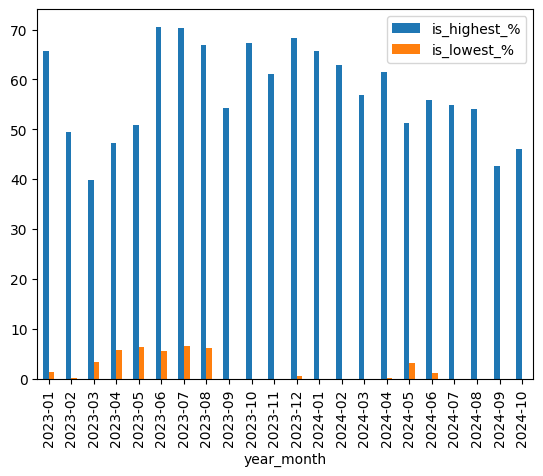

In [184]:
df_cat2_prices_evolution_monthly[['is_highest_%', 'is_lowest_%']].plot.bar()

Ok, now that's a huuuugeeee difference. Maybe I should go back and redo the other part.

## 4.4. Reactive pricing behavior between competitors
Explore whether there is a reactive pricing behavior between competitors – i.e., whether price changes from one player are followed by price adjustments from another. Pricing behaviour between competitors is analysed in the short-term (few days to a week periods).

In [261]:
df_cat_prices.head()

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1,competitor-level1,competitor-level2
0,2056,2024-03-12,chain,21.70,0.0000,0,NaN,21.700000,3021101,30211,302,3,chain-3,chain-302
1,4435,2023-06-21,chain,18.92,0.2754,1,weekly,13.709432,3030708,30307,303,3,chain-3,chain-303
2,1951,2023-03-03,competitorA,60.58,0.3524,1,NaN,39.231608,3020806,30208,302,3,competitorA-3,competitorA-302
3,2135,2024-06-05,chain,55.37,0.2509,1,weekly,41.477667,3010801,30108,301,3,chain-3,chain-301
4,3949,2023-05-29,chain,51.90,0.0000,0,NaN,51.900000,1010407,10104,101,1,chain-1,chain-101


In [222]:
df_cat_prices['competitor-level1'] = df_cat_prices.apply(lambda row: f"{row['competitor']}-{row['structure_level_1']}", axis=1)
df_cat_prices['competitor-level2'] = df_cat_prices.apply(lambda row: f"{row['competitor']}-{row['structure_level_2']}", axis=1)

In [262]:
# terrible mistake to do this directly on df_cat_prices...

In [254]:
df_prod_discounts_all.index = df_prod_discounts_all.index.droplevel(level='structure_level_2')

In [258]:
skus_common = pd.DataFrame(df_prod_discounts_all.index)

In [269]:
df_cat_prices_common = df_cat_prices.merge(skus_common, on='sku', how='inner')

In [260]:
skus_common.head()

,sku
0,1254
1,1297
2,1378
3,1379
4,1384


In [268]:
# I might need to check all of this... and it should be moved to the data treatment maybe

In [271]:
df_cat1_prices = df_cat_prices_common.groupby(['time_key', 'competitor-level1']).agg({'price_final': 'mean'})
df_cat1_prices = df_cat1_prices.unstack()
df_cat1_prices.columns = df_cat1_prices.columns.droplevel()

In [272]:
df_cat1_prices.head()

competitor-level1,chain-1,chain-2,chain-3,competitorA-1,competitorA-2,competitorA-3,competitorB-1,competitorB-2,competitorB-3
time_key,,,,,,,,,
2023-01-03,41.534251,51.940432,32.447490,41.948841,52.878477,31.626280,39.039326,46.225531,27.886986
2023-01-04,41.534471,51.945996,32.406761,41.975167,53.209140,32.101675,39.044185,39.681178,27.957893
2023-01-05,41.482689,51.890028,32.408723,42.121011,53.321381,31.987158,39.044185,39.681178,27.957893
2023-01-06,40.418636,56.974315,32.222468,41.829029,53.106016,31.912376,38.739276,39.681178,27.957893
2023-01-07,40.276443,57.057271,32.298622,41.777138,53.106016,31.912376,38.801001,39.681178,27.957893


In [273]:
df_cat1_prices = df_cat1_prices.dropna()

In [274]:
df_cat1_prices.head()

competitor-level1,chain-1,chain-2,chain-3,competitorA-1,competitorA-2,competitorA-3,competitorB-1,competitorB-2,competitorB-3
time_key,,,,,,,,,
2023-01-03,41.534251,51.940432,32.447490,41.948841,52.878477,31.626280,39.039326,46.225531,27.886986
2023-01-04,41.534471,51.945996,32.406761,41.975167,53.209140,32.101675,39.044185,39.681178,27.957893
2023-01-05,41.482689,51.890028,32.408723,42.121011,53.321381,31.987158,39.044185,39.681178,27.957893
2023-01-06,40.418636,56.974315,32.222468,41.829029,53.106016,31.912376,38.739276,39.681178,27.957893
2023-01-07,40.276443,57.057271,32.298622,41.777138,53.106016,31.912376,38.801001,39.681178,27.957893


In [275]:
for column in df_cat1_prices.columns:
    for i in range(1,8):
        df_cat1_prices[f"{column}_lag_{i}"] = df_cat1_prices[column].shift(-i)

In [276]:
df_cat1_prices.columns

Index(['chain-1', 'chain-2', 'chain-3', 'competitorA-1', 'competitorA-2',
       'competitorA-3', 'competitorB-1', 'competitorB-2', 'competitorB-3',
       'chain-1_lag_1', 'chain-1_lag_2', 'chain-1_lag_3', 'chain-1_lag_4',
       'chain-1_lag_5', 'chain-1_lag_6', 'chain-1_lag_7', 'chain-2_lag_1',
       'chain-2_lag_2', 'chain-2_lag_3', 'chain-2_lag_4', 'chain-2_lag_5',
       'chain-2_lag_6', 'chain-2_lag_7', 'chain-3_lag_1', 'chain-3_lag_2',
       'chain-3_lag_3', 'chain-3_lag_4', 'chain-3_lag_5', 'chain-3_lag_6',
       'chain-3_lag_7', 'competitorA-1_lag_1', 'competitorA-1_lag_2',
       'competitorA-1_lag_3', 'competitorA-1_lag_4', 'competitorA-1_lag_5',
       'competitorA-1_lag_6', 'competitorA-1_lag_7', 'competitorA-2_lag_1',
       'competitorA-2_lag_2', 'competitorA-2_lag_3', 'competitorA-2_lag_4',
       'competitorA-2_lag_5', 'competitorA-2_lag_6', 'competitorA-2_lag_7',
       'competitorA-3_lag_1', 'competitorA-3_lag_2', 'competitorA-3_lag_3',
       'competitorA-3_lag_

In [229]:
# this is going to be hammered and ugly, but I'm running out of time

In [277]:
df_prod1_chain_others = df_cat1_prices[['chain-1', 'competitorA-1', 'competitorA-1_lag_1', 'competitorA-1_lag_2', 'competitorA-1_lag_3', 'competitorA-1_lag_4', 'competitorA-1_lag_5', 'competitorA-1_lag_6', 'competitorA-1_lag_7', 'competitorB-1', 'competitorB-1_lag_1', 'competitorB-1_lag_2', 'competitorB-1_lag_3', 'competitorB-1_lag_4', 'competitorB-1_lag_5', 'competitorB-1_lag_6', 'competitorB-1_lag_7']]

In [278]:
df_prod1_chain_others.head()

competitor-level1,chain-1,competitorA-1,competitorA-1_lag_1,competitorA-1_lag_2,competitorA-1_lag_3,competitorA-1_lag_4,competitorA-1_lag_5,competitorA-1_lag_6,competitorA-1_lag_7,competitorB-1,competitorB-1_lag_1,competitorB-1_lag_2,competitorB-1_lag_3,competitorB-1_lag_4,competitorB-1_lag_5,competitorB-1_lag_6,competitorB-1_lag_7
time_key,,,,,,,,,,,,,,,,,
2023-01-03,41.534251,41.948841,41.975167,42.121011,41.829029,41.777138,41.829029,41.829029,42.305762,39.039326,39.044185,39.044185,38.739276,38.801001,38.739276,39.131381,39.429836
2023-01-04,41.534471,41.975167,42.121011,41.829029,41.777138,41.829029,41.829029,42.305762,42.285820,39.044185,39.044185,38.739276,38.801001,38.739276,39.131381,39.429836,39.117364
2023-01-05,41.482689,42.121011,41.829029,41.777138,41.829029,41.829029,42.305762,42.285820,42.180073,39.044185,38.739276,38.801001,38.739276,39.131381,39.429836,39.117364,38.645011
2023-01-06,40.418636,41.829029,41.777138,41.829029,41.829029,42.305762,42.285820,42.180073,41.942274,38.739276,38.801001,38.739276,39.131381,39.429836,39.117364,38.645011,38.645011
2023-01-07,40.276443,41.777138,41.829029,41.829029,42.305762,42.285820,42.180073,41.942274,41.942274,38.801001,38.739276,39.131381,39.429836,39.117364,38.645011,38.645011,38.645011


In [279]:
df_prod1_chain_others_corr = df_prod1_chain_others.corr(method='pearson')

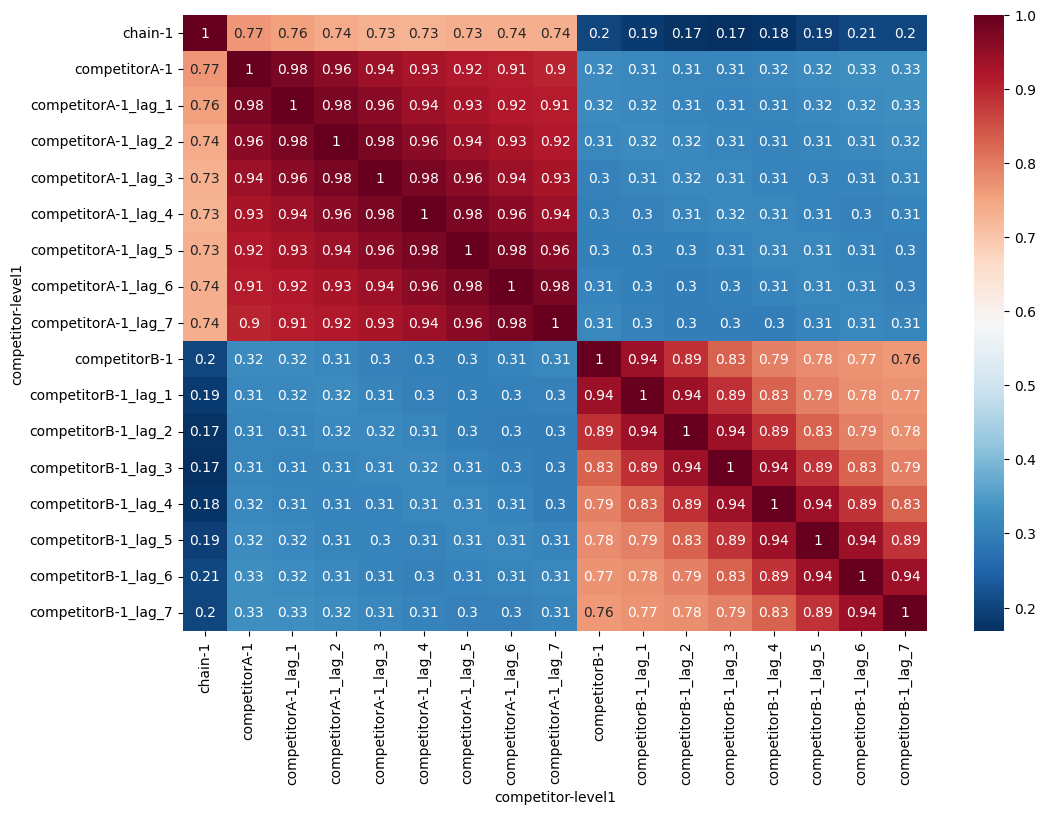

In [281]:
plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(df_prod1_chain_others_corr,
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

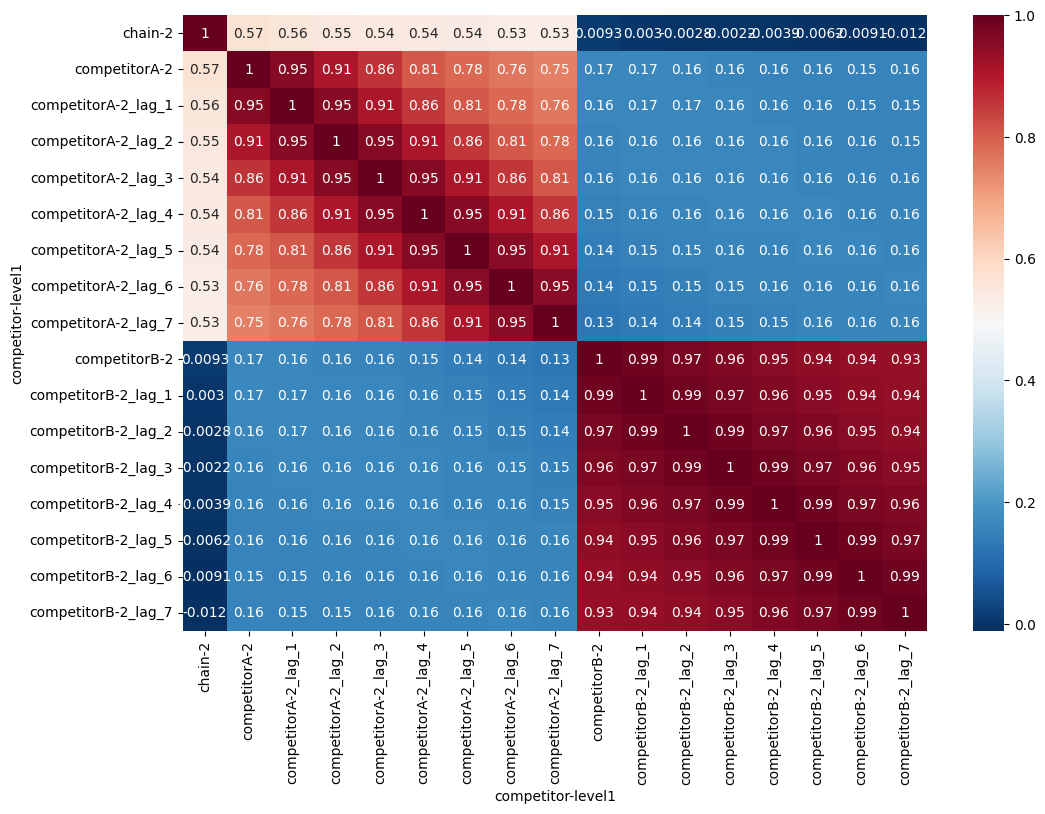

In [282]:
df_prod2_chain_others = df_cat1_prices[['chain-2', 'competitorA-2', 'competitorA-2_lag_1', 'competitorA-2_lag_2', 'competitorA-2_lag_3', 'competitorA-2_lag_4', 'competitorA-2_lag_5', 'competitorA-2_lag_6', 'competitorA-2_lag_7', 'competitorB-2', 'competitorB-2_lag_1', 'competitorB-2_lag_2', 'competitorB-2_lag_3', 'competitorB-2_lag_4', 'competitorB-2_lag_5', 'competitorB-2_lag_6', 'competitorB-2_lag_7']]
df_prod2_chain_others_corr = df_prod2_chain_others.corr(method='pearson')
plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(df_prod2_chain_others_corr,
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

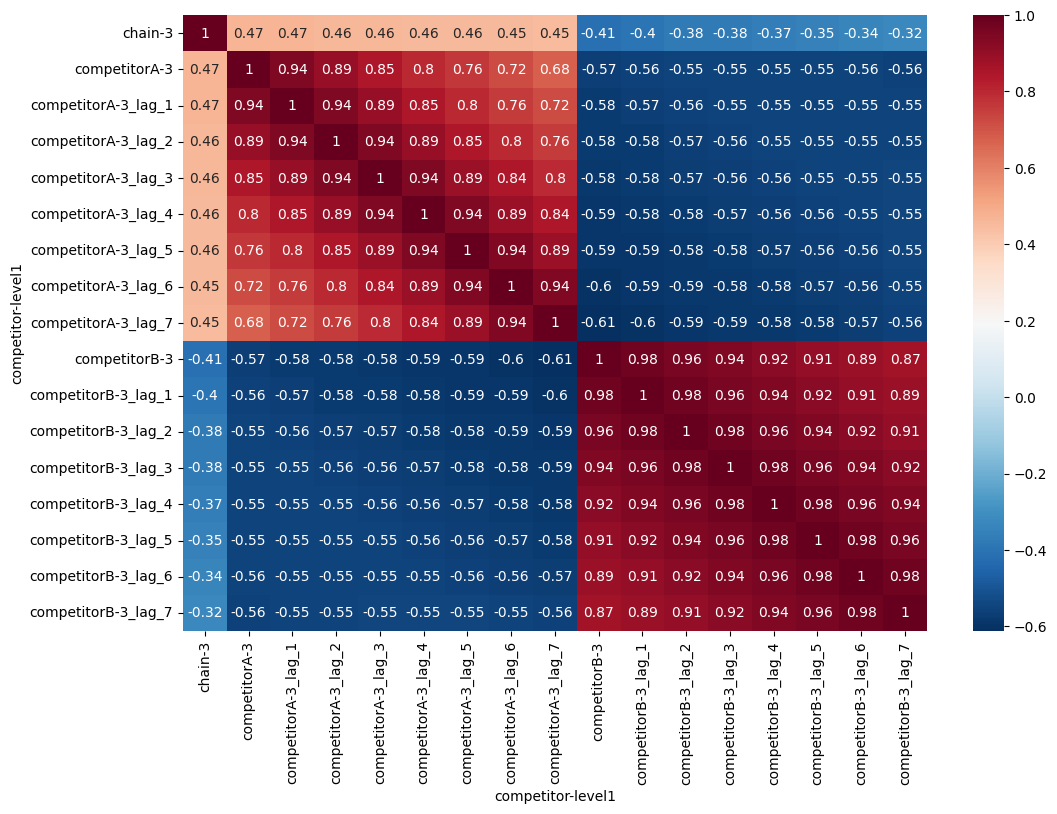

In [283]:
df_prod3_chain_others = df_cat1_prices[['chain-3', 'competitorA-3', 'competitorA-3_lag_1', 'competitorA-3_lag_2', 'competitorA-3_lag_3', 'competitorA-3_lag_4', 'competitorA-3_lag_5', 'competitorA-3_lag_6', 'competitorA-3_lag_7', 'competitorB-3', 'competitorB-3_lag_1', 'competitorB-3_lag_2', 'competitorB-3_lag_3', 'competitorB-3_lag_4', 'competitorB-3_lag_5', 'competitorB-3_lag_6', 'competitorB-3_lag_7']]
df_prod3_chain_others_corr = df_prod3_chain_others.corr(method='pearson')
plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(df_prod3_chain_others_corr,
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

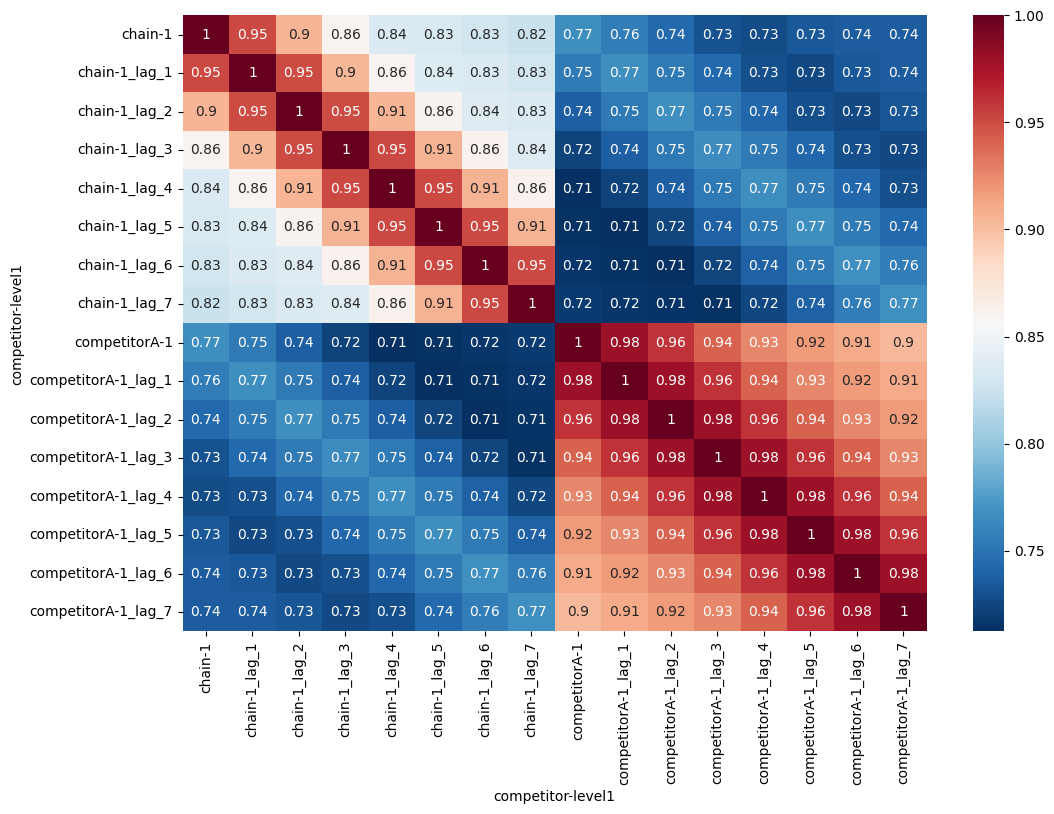

In [284]:
df_prod1_chain_A = df_cat1_prices[['chain-1', 'chain-1_lag_1', 'chain-1_lag_2', 'chain-1_lag_3', 'chain-1_lag_4', 'chain-1_lag_5', 'chain-1_lag_6', 'chain-1_lag_7','competitorA-1', 'competitorA-1_lag_1', 'competitorA-1_lag_2', 'competitorA-1_lag_3', 'competitorA-1_lag_4', 'competitorA-1_lag_5', 'competitorA-1_lag_6', 'competitorA-1_lag_7']]
df_prod1_chain_A_corr = df_prod1_chain_A.corr(method='pearson')
plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(df_prod1_chain_A_corr,
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

Drawing conclusions:
* No effect from chain into competitor B whatsoever, they are very unrelated
* No effect from A in B nor B in A neither
* Prices from chain and A are similar, but... more on the actual day, then previous days don't seem to affect much, so it's hard to tell if they are influencing each other or following along the same signals
* the relationship between A and chain is clearer for category 1
* did it with the whole dataset and then filtering only the common skus - no significant change in results.

In [239]:
df_cat2_prices = df_cat_prices.groupby(['time_key', 'competitor-level2']).agg({'price_final': 'mean'})
df_cat2_prices = df_cat2_prices.unstack()
df_cat2_prices.columns = df_cat2_prices.columns.droplevel()

In [240]:
df_cat2_prices.head()

competitor-level2,chain-101,chain-102,chain-103,chain-104,chain-105,chain-106,chain-201,chain-202,chain-301,chain-302,...,competitorB-104,competitorB-105,competitorB-106,competitorB-201,competitorB-202,competitorB-301,competitorB-302,competitorB-303,competitorB-304,competitorB-305
time_key,,,,,,,,,,,,,,,,,,,,,
2023-01-03,66.031935,41.664949,45.054016,40.537273,42.704074,41.167273,126.696827,38.419017,36.255798,42.806051,...,34.45308,29.775351,27.5325,117.624109,29.535855,27.192004,26.088914,28.398218,26.327,124.275
2023-01-04,66.108893,41.664949,44.706729,40.537273,42.704074,41.167273,126.923999,38.382236,36.243139,42.834842,...,31.53000,29.775351,27.5325,100.607675,29.723565,27.537246,26.088914,28.398218,26.327,124.275
2023-01-05,66.505188,41.629214,44.509710,40.537273,42.704074,41.167273,127.319961,38.375536,36.337629,42.827110,...,31.53000,29.775351,27.5325,100.607675,29.723565,27.537246,26.088914,28.398218,26.327,124.275
2023-01-06,65.063462,41.046348,42.900965,40.537273,42.704074,41.167273,122.368846,36.907303,36.313956,42.803998,...,31.53000,29.775351,27.5325,100.607675,29.723565,27.537246,26.088914,28.398218,26.327,124.275
2023-01-07,64.504039,41.046348,44.343235,40.537273,42.704074,41.167273,122.368846,37.113462,36.361235,42.908813,...,31.53000,29.775351,27.5325,100.607675,29.723565,27.537246,26.088914,28.398218,26.327,124.275


In [241]:
df_cat2_prices.columns

Index(['chain-101', 'chain-102', 'chain-103', 'chain-104', 'chain-105',
       'chain-106', 'chain-201', 'chain-202', 'chain-301', 'chain-302',
       'chain-303', 'chain-304', 'chain-305', 'competitorA-101',
       'competitorA-102', 'competitorA-103', 'competitorA-104',
       'competitorA-105', 'competitorA-106', 'competitorA-201',
       'competitorA-202', 'competitorA-301', 'competitorA-302',
       'competitorA-303', 'competitorA-304', 'competitorA-305',
       'competitorB-101', 'competitorB-102', 'competitorB-103',
       'competitorB-104', 'competitorB-105', 'competitorB-106',
       'competitorB-201', 'competitorB-202', 'competitorB-301',
       'competitorB-302', 'competitorB-303', 'competitorB-304',
       'competitorB-305'],
      dtype='object', name='competitor-level2')